In [1]:
import polars as pl
import polars_distance as pld
from pprint import pprint
from loguru import logger
import polars.selectors as cs
import kuzu as kz
from pathlib import Path
from typing import Type, Callable
from usearch.index import Index, Matches
import numpy as np
from typing import NamedTuple, Self, TypedDict
from functools import partial
from numpy.typing import NDArray
import duckdb
from duckdb import DuckDBPyConnection
from time import time

pl.Config.set_tbl_rows(20)

polars.config.Config

In [2]:
duck_db_path = Path("./data/db/duck_db/data.db")
duck_db_path.parent.mkdir(parents=True, exist_ok=True)

con = duckdb.connect(database=duck_db_path.as_posix())

con.execute("SET enable_progress_bar = false;")
con.install_extension("spatial")
con.load_extension("spatial")

# Set DuckDB optimizations
con.execute("PRAGMA memory_limit='16GB'")  # Adjust based on your system
con.execute("PRAGMA threads=8")  # Adjust based on your CPU cores
con.execute("PRAGMA enable_object_cache=true")  # Improve query caching
# con.execute("PRAGMA profiling_mode = 'standard'")  # Set profiling mode
# con.execute("PRAGMA enable_profiling = 'json'")  # Enable profiling
# con.execute("PRAGMA profiling_output = './profile.json'")  # Set profiling output


In [3]:
con.execute(
    """SELECT * , fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score

        FROM admin_search
        WHERE fts_score IS NOT NULL
            """,
    {"term": "Kenya"},
).pl()

geonameId,name,asciiname,admin_level,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,ISO,ISO3,ISO_Numeric,official_name,fips,latitude,longitude,population,area,alternatenames,country_name,fts_score
u32,str,str,u8,str,str,str,str,str,str,str,str,str,u16,str,str,f32,f32,i32,f32,str,str,f64
10861316,"""Kenya""","""Kenya""",3,"""CD""","""05""",null,"""10861316""",null,"""A""","""ADM3""",null,null,null,null,null,-11.69712,27.479509,0,null,null,"""Democratic Republic of the Con…",8.966241
192950,"""Republic of Kenya""","""Republic of Kenya""",0,"""KE""",null,null,null,null,"""A""","""PCLI""","""KE""","""KEN""",404,"""Kenya""","""KE""",1.0,38.0,51393010,582650.0,"""A Cheinia,Ceinia,Cenia,Chenia,…","""Kenya""",6.047672
400741,"""Eastern Province""","""Eastern Province""",1,"""KE""","""03""",null,null,null,"""A""","""ADM1H""",null,null,null,null,null,0.0,38.0,4631779,null,"""Aust-Kenya,Eastern,Eastern Pro…","""Republic of Kenya""",6.944599


In [4]:
SQL_FOLDER = Path("./sql")


def sql_file(sql_path: Path | str, **kwargs) -> str:
    if isinstance(sql_path, str):
        sql_path = Path(sql_path)
    if not sql_path.exists():
        sql_path = SQL_FOLDER / sql_path
        if not sql_path.exists():
            raise FileNotFoundError(f"SQL file {sql_path} not found")
    sql = sql_path.read_text()
    if kwargs:
        sql = sql.format(**kwargs)

    # Validate no {kwarg} left in string (regex)
    # if uninit_kwargs := re.findall(r"\{.*\}", sql):
    #     raise ValueError(
    #         f"SQL file {sql_path} still has unprocessed kwargs: {list(set(uninit_kwargs))} in:\n\n{sql}"
    #     )

    return sql

In [5]:
GID = "geonameId"


def table_exists(con: DuckDBPyConnection, table_name: str) -> bool:
    return table_name in con.execute("SHOW TABLES").pl()["name"]


# Read and load 'allCountries.txt'
# Function to read and load other files with different schemas
def load_file(
    # con: DuckDBPyConnection,
    file_path: str,
    schema: dict[str, Type[pl.DataType]],
    table_name: str,
    table_definition: str | None = None,
    pipe: Callable[[pl.LazyFrame], pl.LazyFrame] | None = None,
    has_header: bool = False,
    skip_rows: int = 0,
    overwrite: bool = False,
    extra_expr: pl.Expr | None = None,
):
    if table_exists(con, table_name):
        logger.debug(f"Table '{table_name}' already exists")
        if not overwrite:
            return
        logger.debug(f"Overwriting table '{table_name}'")
        con.execute(f"DROP TABLE {table_name} CASCADE")
        logger.debug(f"Table '{table_name}' dropped")
    time_start = time()
    load = con.begin()
    try:
        logger.info(f"Loading '{file_path}'...")
        # Time scan
        time_scan = time()
        q = pl.scan_csv(
            file_path,
            separator="\t",
            has_header=has_header,
            schema=schema,
            skip_rows=skip_rows,
        )
        q = q.with_columns(
            pl.col(pl.Utf8).str.strip_chars().str.strip_chars("\"':").str.strip_chars()
        )
        if extra_expr is not None:
            q = q.with_columns(extra_expr)
        if pipe is not None:
            q = q.pipe(pipe)
        if GID in schema:
            q = q.sort(GID, nulls_last=True)
        logger.debug(f"Scan time: {time() - time_scan:.6f}s")

        q = q.with_columns(cs.by_dtype(pl.String).str.strip_chars().replace("", None))

        # Time collect
        time_collect = time()
        df = q.collect()
        logger.debug(f"Collect time: {time() - time_collect:.6f}s")

        # Time write
        time_write = time()
        save_path = Path(f"./data/processed/geonames/{table_name}.parquet")
        save_path.parent.mkdir(parents=True, exist_ok=True)
        df.write_parquet(save_path.as_posix())
        logger.debug(f"Write time: {time() - time_write:.6f}s")

        # Time create
        time_create = time()
        # Create table with predefined schema if provided
        time_create = time()
        if table_definition:
            # Create the table with specified schema
            load.execute(table_definition)
            load.from_arrow(df.to_arrow()).insert_into(table_name)
        else:
            # Use automatic schema derivation (your current approach)
            load.from_arrow(df.to_arrow()).create(table_name)

        logger.debug(f"Create time: {time() - time_create:.6f}s")

        time_commit = time()
        load.commit()
        logger.debug(f"Commit time: {time() - time_commit:.6f}s")
        analyze_time = time()
        con.execute("VACUUM ANALYZE;")
        logger.debug(f"Analyze time: {time() - analyze_time:.6f}s")
    except Exception as e:
        logger.exception("Error loading '{file_path}'")
        logger.debug(e.with_traceback(None))
        # Time rollback
        time_rollback = time()
        load.rollback()
        logger.warning(f"Rollback time: {time() - time_rollback:.6f}s")
        raise e
    finally:
        logger.info(f"Total time: {time() - time_start:.6f}s")
    return df


def drop_duplicates(df: pl.LazyFrame) -> pl.LazyFrame:
    cols = [
        "name",
        "asciiname",
        "feature_class",
        "feature_code",
        "admin0_code",
        "admin1_code",
        "admin2_code",
        "admin3_code",
        "admin4_code",
        "timezone",
    ]
    return (
        df.sort("modification_date", descending=True)
        .unique(cols, keep="first")
        .filter(~pl.all_horizontal(pl.col(cols).is_null()))
        .sort("geonameId")
    )


schema_all_countries = {
    GID: pl.UInt32,
    "name": pl.Utf8,
    "asciiname": pl.Utf8,
    "alternatenames": pl.Utf8,
    "latitude": pl.Float32,
    "longitude": pl.Float32,
    "feature_class": pl.Categorical,
    "feature_code": pl.Categorical,
    "admin0_code": pl.Categorical,
    "cc2": pl.Utf8,
    "admin1_code": pl.Utf8,
    "admin2_code": pl.Utf8,
    "admin3_code": pl.Utf8,
    "admin4_code": pl.Utf8,
    "population": pl.Int64,
    "elevation": pl.Int32,
    "dem": pl.Int32,
    "timezone": pl.Categorical,
    "modification_date": pl.Date,
}


load_file(
    "./data/raw/geonames/allCountries.txt",
    schema_all_countries,
    "allCountries",
    table_definition=sql_file("create_table_allCountries.sql"),
    pipe=drop_duplicates,
)


load_file(
    "./data/raw/geonames/allCountriesPostCode.txt",
    {
        "admin_code0": pl.Categorical,
        "postal_code": pl.Utf8,
        "place_name": pl.Utf8,
        "admin_name1": pl.Utf8,
        "admin_code1": pl.Utf8,
        "admin_name2": pl.Utf8,
        "admin_code2": pl.Utf8,
        "admin_name3": pl.Utf8,
        "admin_code3": pl.Utf8,
        "latitude": pl.Float32,
        "longitude": pl.Float32,
        "accuracy": pl.Int32,
    },
    "allPostCodes",
)


# Load other files with respective schemas
load_file(
    "./data/raw/geonames/admin1CodesASCII.txt",
    {
        "code": pl.Utf8,
        "name": pl.Utf8,
        "name_ascii": pl.Utf8,
        GID: pl.UInt32,
    },
    "admin1CodesASCII",
    table_definition=sql_file("create_table_admin1CodesASCII.sql"),
)

load_file(
    "./data/raw/geonames/admin2Codes.txt",
    {
        "code": pl.Utf8,
        "name": pl.Utf8,
        "asciiname": pl.Utf8,
        GID: pl.UInt32,
    },
    "admin2Codes",
    table_definition=sql_file("create_table_admin2Codes.sql"),
)


def drop_invalid_gids(df: pl.LazyFrame, con: DuckDBPyConnection) -> pl.LazyFrame:
    ids = con.execute("SELECT geonameId FROM allCountries").pl().unique().to_series()
    return df.filter(pl.col(GID).is_in(ids))


load_file(
    "./data/raw/geonames/adminCode5.txt",
    {
        GID: pl.UInt32,
        "adm5code": pl.Utf8,
    },
    "adminCode5",
    table_definition=sql_file("create_table_adminCode5.sql"),
    pipe=partial(drop_invalid_gids, con=con),
)


load_file(
    "./data/raw/geonames/alternateNamesV2.txt",
    {
        "alternateNameId": pl.Int32,
        GID: pl.UInt32,
        "isolanguage": pl.Utf8,
        "alternate_name": pl.Utf8,
        "isPreferredName": pl.Int8,
        "isShortName": pl.Int8,
        "isColloquial": pl.Int8,
        "isHistoric": pl.Int8,
        "from": pl.Utf8,
        "to": pl.Utf8,
    },
    "alternateNamesV2",
    table_definition=sql_file("create_table_alternateNamesV2.sql"),
    extra_expr=cs.by_dtype(pl.Int8).cast(pl.Boolean).fill_null(False),
    pipe=partial(drop_invalid_gids, con=con),
)

load_file(
    "./data/raw/geonames/countryInfo.txt",
    {
        "ISO": pl.Categorical,
        "ISO3": pl.Categorical,
        "ISO_Numeric": pl.Int32,
        "fips": pl.Categorical,
        "Country": pl.Utf8,
        "Capital": pl.Utf8,
        "Area": pl.Float32,
        "Population": pl.Int32,
        "Continent": pl.Categorical,
        "tld": pl.Utf8,
        "CurrencyCode": pl.Utf8,
        "CurrencyName": pl.Utf8,
        "Phone": pl.Utf8,
        "Postal_Code_Format": pl.Utf8,
        "Postal_Code_Regex": pl.Utf8,
        "Languages": pl.Utf8,
        GID: pl.UInt32,
        "neighbours": pl.Utf8,
        "EquivalentFipsCode": pl.Utf8,
    },
    "countryInfo",
    table_definition=sql_file("create_table_countryInfo.sql"),
    skip_rows=51,
)

load_file(
    "./data/raw/geonames/featureCodes_en.txt",
    {
        "code": pl.Categorical,
        "name": pl.Utf8,
        "description": pl.Utf8,
    },
    "featureCodes",
    table_definition=sql_file("create_table_featureCodes.sql"),
)


def remove_old_ids(df: pl.LazyFrame, con: DuckDBPyConnection) -> pl.LazyFrame:
    ids = con.execute("SELECT geonameId FROM allCountries").pl().unique().to_series()
    return (
        df.filter(pl.col("parentId").is_in(ids) & pl.col("childId").is_in(ids))
        .with_columns(
            pl.when(pl.col("type").str.contains("adm", literal=True))
            .then(pl.col("type").str.to_uppercase())
            .otherwise(pl.col("type"))
        )
        .unique(["parentId", "childId"])
    )


load_file(
    "./data/raw/geonames/hierarchy.txt",
    {
        "parentId": pl.UInt32,
        "childId": pl.UInt32,
        "type": pl.Utf8,
    },
    "hierarchy",
    table_definition=sql_file("create_table_hierarchy.sql"),
    pipe=partial(remove_old_ids, con=con),
)
con.execute(sql_file("create_table_unique_ids.sql"))

load_file(
    "./data/raw/geonames/iso-languagecodes.txt",
    {
        "ISO_639_3": pl.Utf8,
        "ISO_639_2": pl.Utf8,
        "ISO_639_1": pl.Utf8,
        "Language_Name": pl.Utf8,
    },
    "iso_languagecodes",
    table_definition=sql_file("create_table_iso_languagecodes.sql"),
)


load_file(
    "./data/raw/geonames/timeZones.txt",
    {
        "CountryCode": pl.Utf8,
        "TimeZoneId": pl.Utf8,
        "GMT_offset_1_Jan_2024": pl.Float32,
        "DST_offset_1_Jul_2024": pl.Float32,
        "rawOffset": pl.Float32,
    },
    "timeZones",
    table_definition=sql_file("create_table_timeZones.sql"),
    skip_rows=1,
)
# # Ignore loading the geo data for now
if not table_exists(con, "shapes"):
    con.execute(sql_file("create_table_shapes.sql"))
    logger.debug("Table 'shapes' created")

# # File is corupted atm
# load_file(
#     "./data/raw/geonames/userTags.txt",
#     {
#         GID: pl.Int32,
#         "tag": pl.Utf8,
#     },
#     "userTags",
# )
con.execute(sql_file("create_table_equivalent.sql"))
con.execute(sql_file("create_view_cities.sql"))
con.execute(sql_file("create_view_locations_full.sql"))

2025-05-07 10:33:19.798 | DEBUG    | __main__:load_file:23 - Table 'allCountries' already exists
2025-05-07 10:33:19.801 | DEBUG    | __main__:load_file:23 - Table 'allPostCodes' already exists
2025-05-07 10:33:19.804 | DEBUG    | __main__:load_file:23 - Table 'admin1CodesASCII' already exists
2025-05-07 10:33:19.807 | DEBUG    | __main__:load_file:23 - Table 'admin2Codes' already exists
2025-05-07 10:33:19.810 | DEBUG    | __main__:load_file:23 - Table 'adminCode5' already exists
2025-05-07 10:33:19.813 | DEBUG    | __main__:load_file:23 - Table 'alternateNamesV2' already exists
2025-05-07 10:33:19.816 | DEBUG    | __main__:load_file:23 - Table 'countryInfo' already exists
2025-05-07 10:33:19.820 | DEBUG    | __main__:load_file:23 - Table 'featureCodes' already exists
2025-05-07 10:33:19.823 | DEBUG    | __main__:load_file:23 - Table 'hierarchy' already exists
2025-05-07 10:33:19.827 | DEBUG    | __main__:load_file:23 - Table 'iso_languagecodes' already exists
2025-05-07 10:33:19.830 

In [6]:
# Create country table
# con.execute(sql_file("create_table_equivalent.sql")).pl()
# con.execute(sql_file("create_table_admin0.sql")).execute("""PRAGMA create_fts_index(
#     admin0,
#     geonameId,
#     name,
#     asciiname,
#     official_name,
#     alternatenames,
#     admin0_code,
#     ISO3,
#     ISO_Numeric,
#     fips,
#     stemmer = 'none',
#     stopwords = 'none',
#     ignore = '(\\.|[^a-z0-9])+',
#     overwrite = 1
# );""")


In [7]:
entities_df = con.execute(f"""
    SELECT {GID}, name, feature_class, feature_code
    FROM unique_ids
""").pl()

hierarchy_df = con.execute("""
    SELECT parentId, childId, type
    FROM hierarchy
""").pl()
logger.debug(
    f"Loaded {len(entities_df)} entities and {len(hierarchy_df)} hierarchical relationships"
)
logger.debug("Entity columns:", entities_df.columns)
logger.debug("Hierarchy columns:", hierarchy_df.columns)

# 2. Setup Kuzu database connection
gdb_path = Path("./data/db/graph_db")
gdb_path.mkdir(parents=True, exist_ok=True)
gdb = kz.Database(gdb_path.as_posix())
conn = kz.Connection(gdb)

# 3. Create the schema in Kuzu if needed
if "Entity" not in conn.execute("CALL SHOW_TABLES() RETURN *;").get_as_pl().get_column(
    "name"
):
    conn.execute(sql_file("create_node_entity.sql"))
    logger.debug("Created Entity table")

if "IsIn" not in conn.execute("CALL SHOW_TABLES() RETURN *;").get_as_pl().get_column(
    "name"
):
    conn.execute(sql_file("create_relation_IsIn.sql"))
    logger.debug("Created IsIn table")

    # 4. Check if tables already have data
are_nodes = (
    conn.execute("MATCH (e:Entity) RETURN count(e) > 0 AS HasData")
    .get_as_pl()
    .get_column("HasData")[0]
)
are_edges = (
    conn.execute("MATCH ()-[r:IsIn]->() RETURN count(r) > 0 AS HasData")
    .get_as_pl()
    .get_column("HasData")[0]
)

if not are_nodes:
    conn.execute(
        f"COPY Entity FROM (LOAD FROM entities_df RETURN {GID}, name, feature_class, feature_code)"
    )
    logger.debug("Loaded Entity")

if not are_edges:
    conn.execute(
        "COPY IsIn FROM (LOAD FROM hierarchy_df RETURN parentId, childId, type)"
    )
    logger.debug("Loaded IsIn")

2025-05-07 10:33:20.743 | DEBUG    | __main__:<module>:10 - Loaded 534106 entities and 508066 hierarchical relationships
2025-05-07 10:33:20.744 | DEBUG    | __main__:<module>:13 - Entity columns:
2025-05-07 10:33:20.744 | DEBUG    | __main__:<module>:14 - Hierarchy columns:


In [8]:
def get_children_query(geoname_id: int) -> str:
    query = f"""MATCH (p:Entity {{geonameId: {geoname_id}}})-[:IsIn]->(c:Entity)
    RETURN c.{GID} AS {GID}, c.name AS name, c.feature_class AS feature_class, c.feature_code AS feature_code;"""
    return query


def get_parents_query(geoname_id):
    query = f"""MATCH (c:Entity {{geonameId: {geoname_id}}})<-[:IsIn]-(p:Entity)
    RETURN p.{GID} AS {GID}, p.name AS name, p.feature_class AS feature_class, p.feature_code AS feature_code;"""
    return query


# MATCH (c:Entity) WHERE CAST(c.geonameId, "INT64") IN list_creation({formatted_ids}) RETURN *;
def get_children_querys(
    geoname_ids: list[int] | pl.Series, traverse: bool = False
) -> str:
    query = f"""MATCH (p:Entity)-[:IsIn{"*" if traverse else ""}]->(c:Entity)
    WHERE p.geonameId IN CAST({geoname_ids}, "UINT32[]")
    RETURN DISTINCT c.{GID} AS {GID}, c.name AS name, c.feature_class AS feature_class, c.feature_code AS feature_code;"""
    return query


def get_parents_querys(
    geoname_ids: list[int] | pl.Series, traverse: bool = False
) -> str:
    query = f"""MATCH (c:Entity)<-[:IsIn{"*" if traverse else ""}]-(p:Entity)
    WHERE c.geonameId IN CAST({geoname_ids}, "UINT32[]")
    RETURN DISTINCT p.{GID} AS {GID}, p.name AS name, p.feature_class AS feature_class, p.feature_code AS feature_code;"""
    return query


def get_highest_parent_query():
    query = f"""
    MATCH (entity:Entity)
    WHERE NOT (entity)<-[:IsIn]-(:Entity)
    RETURN entity.{GID} AS {GID}, entity.name AS name, entity.feature_class AS feature_class, entity.feature_code AS feature_code;"""
    return query


conn.execute(get_parents_query(49518)).get_as_pl()
conn.execute(get_children_query(6252001)).get_as_pl()
conn.execute(get_children_querys([49518, 51537])).get_as_pl()
conn.execute(get_parents_querys([49518, 51537])).get_as_pl()

geonameId,name,feature_class,feature_code
i32,str,str,str
11820342,"""Horn of Africa""","""L""","""RGN"""
6255146,"""Africa""","""L""","""CONT"""
7729889,"""Eastern Africa""","""L""","""RGN"""
11812257,"""Commonwealth of Nations""","""A""","""ZN"""


In [9]:
def build_unified_admin_table(con, conn=None, overwrite=True):
    """Build a simplified admin_search table focusing on admin codes for hierarchy."""

    logger.debug("Starting simplified admin search table construction...")

    # Check if table exists
    if table_exists(con, "admin_search") and not overwrite:
        logger.debug("Table admin_search already exists. Skipping.")
        con.execute("VACUUM ANALYZE;")
        return

    # Create the table with proper schema
    con.execute(sql_file("create_unified_admin_table.sql"))

    # Define admin level feature code patterns
    level_codes = {
        0: ["PCL", "PCLI", "PCLD", "PCLF", "PCLS", "TERR"],
        1: ["ADM1", "ADM1H"],
        2: ["ADM2", "ADM2H"],
        3: ["ADM3", "ADM3H"],
        4: ["ADM4", "ADM4H"],
    }

    # Process each admin level
    for level in range(0, 5):
        logger.info(f"Processing admin level {level} entities...")

        # Identify entities of this admin level by feature code
        feature_patterns = "', '".join([code for code in level_codes[level]])

        # Direct insert of entities with the matching feature codes
        if level == 0:  # Countries (admin0)
            insert_query = f"""
            INSERT INTO admin_search
            SELECT
                a.geonameId,
                a.name,
                a.asciiname,
                0 AS admin_level,
                a.admin0_code,
                NULL AS admin1_code,
                NULL AS admin2_code,
                NULL AS admin3_code,
                NULL AS admin4_code,
                a.feature_class,
                a.feature_code,
                c.ISO,
                c.ISO3,
                c.ISO_Numeric,
                c.Country AS official_name,
                c.fips,
                a.latitude,
                a.longitude,
                c.population,
                c.area,
                a.alternatenames,
                c.Country AS country_name
            FROM
                allCountries a
            LEFT JOIN
                countryInfo c ON a.geonameId = c.geonameId
            WHERE
                a.feature_code IN ('{feature_patterns}')
                OR a.feature_code LIKE '{level_codes[level][0]}%'
            """
        else:
            # For admin levels 1-4
            insert_query = f"""
            INSERT INTO admin_search
            SELECT
                a.geonameId,
                a.name,
                a.asciiname,
                {level} AS admin_level,
                a.admin0_code,
                {("a.admin1_code" if level >= 1 else "NULL::VARCHAR AS admin1_code")},
                {("a.admin2_code" if level >= 2 else "NULL::VARCHAR AS admin2_code")},
                {("a.admin3_code" if level >= 3 else "NULL::VARCHAR AS admin3_code")},
                {("a.admin4_code" if level >= 4 else "NULL::VARCHAR AS admin4_code")},
                a.feature_class,
                a.feature_code,
                NULL AS ISO,
                NULL AS ISO3,
                NULL AS ISO_Numeric,
                NULL AS official_name,
                NULL AS fips,
                a.latitude,
                a.longitude,
                a.population,
                NULL AS area,
                a.alternatenames,
                c.name AS country_name
            FROM
                allCountries a
            LEFT JOIN
                allCountries c ON a.admin0_code = c.admin0_code AND c.feature_code = 'PCLI'
            WHERE
                (a.feature_code IN ('{feature_patterns}')
                OR a.feature_code LIKE '{level_codes[level][0]}%')
                AND a.admin0_code IS NOT NULL
            """

        # Execute the query to insert data
        con.execute(insert_query)

        # Report count
        count = con.execute(
            f"SELECT COUNT(*) FROM admin_search WHERE admin_level = {level}"
        ).fetchone()[0]
        logger.debug(f"Added {count} entities for admin level {level}")

    # Create FTS index for the unified table
    logger.debug("Creating FTS index for admin_search table...")
    con.execute("""
    PRAGMA create_fts_index(
        admin_search,
        geonameId,
        name, asciiname, alternatenames, official_name, ISO, ISO3,
        stemmer = 'none',
        stopwords = 'none',
        ignore = '(\\.|[^a-z0-9])+',
        overwrite = 1
    )
    """)

    # Final optimization
    logger.debug("Running VACUUM ANALYZE to optimize the database...")
    con.execute("VACUUM ANALYZE;")

    logger.debug("Admin search table construction complete!")
    logger.debug("Writing admin_search table to parquet...")
    con.table("admin_search").pl().write_parquet(
        Path("./data/processed/geonames/admin_search.parquet").as_posix(),
        partition_by=["admin_level"],
    )
    logger.debug("Admin search table written to parquet.")


build_unified_admin_table(con, conn, overwrite=False)

2025-05-07 10:33:20.890 | DEBUG    | __main__:build_unified_admin_table:4 - Starting simplified admin search table construction...
2025-05-07 10:33:20.894 | DEBUG    | __main__:build_unified_admin_table:8 - Table admin_search already exists. Skipping.


In [10]:
def build_places_search_table(con, overwrite=True):
    """Build places_search table with balanced importance scoring."""

    logger.debug("Starting places search table construction...")

    if table_exists(con, "places_search") and not overwrite:
        logger.debug("Table places_search already exists. Skipping.")
        return

    # Create the table with physical importance_tier column
    con.execute(sql_file("create_places_search_table.sql"))

    # Define feature categories with more nuanced scoring
    feature_categories = {
        "major_populated": {
            "codes": [
                "PPLA",
                "PPLA2",
                "PPLA3",
                "PPLA4",
                "PPLC",
                "PPLF",
                "PPLG",
                "PPLR",
                "PPLS",
            ],
            "min_population": 0,
            "base_score": 0.6,
            "pop_weight": 0.7,
            "feature_weight": 0.3,
        },
        "landmarks": {
            "codes": [
                "CSTL",
                "MNMT",
                "RUIN",
                "TOWR",
                "ARCH",
                "HSTS",
                "CAVE",
                "ANS",
                "THTR",
                "AMTH",
                "MUS",
                "LIBR",
                "OPRA",
                "PAL",
                "PGDA",
                "TMPL",
                "SHRN",
                "CH",
                "MSQE",
                "SYG",
                "CVNT",
                "MTRO",
                "AIRP",
                "PRT",
                "RSTN",
                "BUSTN",
                "MAR",
            ],
            "min_population": 0,
            "base_score": 0.4,
            "pop_weight": 0.3,
            "feature_weight": 0.7,
        },
        "natural_features": {
            "codes": [
                "MT",
                "PK",
                "PASS",
                "VLC",
                "ISL",
                "BCH",
                "BAY",
                "CAPE",
                "LK",
                "FLLS",
                "CNYN",
                "VAL",
                "DSRT",
                "GLCR",
                "RSV",
            ],
            "min_population": 0,
            "base_score": 0.3,
            "pop_weight": 0.2,
            "feature_weight": 0.8,
        },
        "facilities": {
            "codes": [
                "HTL",
                "RSRT",
                "MALL",
                "MKT",
                "SCH",
                "UNIV",
                "HSP",
                "ZOO",
                "STDM",
                "PRK",
                "RECG",
                "RECR",
                "SPA",
                "ATHF",
                "ASYL",
            ],
            "min_population": 0,
            "base_score": 0.2,
            "pop_weight": 0.5,
            "feature_weight": 0.5,
        },
        "infrastructure": {
            "codes": [
                "BDG",
                "DAM",
                "LOCK",
                "LTHSE",
                "BRKW",
                "PIER",
                "QUAY",
                "PRMN",
                "OILR",
                "PS",
                "PSH",
                "PSN",
                "CTRM",
                "CTRF",
            ],
            "min_population": 0,
            "base_score": 0.15,
            "pop_weight": 0.3,
            "feature_weight": 0.7,
        },
        "government": {
            "codes": [
                "ADMF",
                "GOVL",
                "CTHSE",
                "DIP",
                "BANK",
                "PO",
                "PP",
                "CSTM",
                "SCHC",
                "MILB",
                "INSM",
            ],
            "min_population": 0,
            "base_score": 0.25,
            "pop_weight": 0.4,
            "feature_weight": 0.6,
        },
    }

    # Process each category with improved scoring
    for category, config in feature_categories.items():
        logger.info(f"Processing {category} features...")

        feature_codes = "', '".join(config["codes"])

        calculation = f"""
        {config["base_score"]} +
                    (
                        CASE
                            WHEN a.population > 10000000 THEN 0.4
                            WHEN a.population > 1000000 THEN 0.35
                            WHEN a.population > 100000 THEN 0.3
                            WHEN a.population > 10000 THEN 0.25
                            WHEN a.population > 1000 THEN 0.2
                            WHEN a.population > 100 THEN 0.15
                            WHEN a.population > 0 THEN 0.1
                            ELSE 0.05
                        END * {config["pop_weight"]}
                        +
                        CASE
                            WHEN a.feature_code IN ('PPLC', 'CSTL', 'MNMT') THEN 0.4
                            WHEN a.feature_code IN ('AIRP', 'TOWR', 'MUS', 'RUIN', 'PAL', 'PGDA') THEN 0.35
                            WHEN a.feature_code IN ('UNIV', 'PPLA', 'RSTN', 'MAR', 'HTL') THEN 0.3
                            WHEN a.feature_code IN ('MT', 'PK', 'VLC', 'ISL', 'BCH') THEN 0.25
                            WHEN a.feature_code IN ('CH', 'HSP', 'SCH', 'THTR', 'STDM') THEN 0.2
                            ELSE 0.1
                        END * {config["feature_weight"]}
                        +
                        CASE
                            WHEN LENGTH(a.alternatenames) > 1000 THEN 0.2
                            WHEN LENGTH(a.alternatenames) > 500 THEN 0.15
                            WHEN LENGTH(a.alternatenames) > 100 THEN 0.1
                            WHEN LENGTH(a.alternatenames) > 0 THEN 0.05
                            ELSE 0
                        END * 0.2
                    )"""

        insert_query = f"""
        INSERT INTO places_search
        SELECT
            a.geonameId,
            a.name,
            a.asciiname,
            a.admin0_code,
            a.admin1_code,
            a.admin2_code,
            a.admin3_code,
            a.admin4_code,
            a.feature_class,
            a.feature_code,
            f.name AS feature_name,
            a.latitude,
            a.longitude,
            a.population,
            a.elevation,
            a.alternatenames,
            c.Country AS country_name,
            -- More balanced importance scoring
            {config["base_score"]} +
            (
                -- Population component
                CASE
                    WHEN a.population > 10000000 THEN 0.4
                    WHEN a.population > 1000000 THEN 0.35
                    WHEN a.population > 100000 THEN 0.3
                    WHEN a.population > 10000 THEN 0.25
                    WHEN a.population > 1000 THEN 0.2
                    WHEN a.population > 100 THEN 0.15
                    WHEN a.population > 0 THEN 0.1
                    ELSE 0.05
                END * {config["pop_weight"]}
                +
                -- Feature type component
                CASE
                    -- Capital cities and major landmarks
                    WHEN a.feature_code IN ('PPLC', 'CSTL', 'MNMT') THEN 0.4
                    -- Major tourist destinations
                    WHEN a.feature_code IN ('AIRP', 'TOWR', 'MUS', 'RUIN', 'PAL', 'PGDA') THEN 0.35
                    -- Important facilities
                    WHEN a.feature_code IN ('UNIV', 'PPLA', 'RSTN', 'MAR', 'HTL') THEN 0.3
                    -- Notable natural features
                    WHEN a.feature_code IN ('MT', 'PK', 'VLC', 'ISL', 'BCH') THEN 0.25
                    -- General infrastructure
                    WHEN a.feature_code IN ('CH', 'HSP', 'SCH', 'THTR', 'STDM') THEN 0.2
                    -- Other features
                    ELSE 0.1
                END * {config["feature_weight"]}
                +
                -- Name recognition bonus (if it has many alternate names)
                CASE
                    WHEN LENGTH(a.alternatenames) > 1000 THEN 0.2
                    WHEN LENGTH(a.alternatenames) > 500 THEN 0.15
                    WHEN LENGTH(a.alternatenames) > 100 THEN 0.1
                    WHEN LENGTH(a.alternatenames) > 0 THEN 0.05
                    ELSE 0
                END * 0.2
            ) AS importance_score,
            -- Calculate tier directly during insert
            CASE
                WHEN (
                    {calculation}

                ) >= 0.8 THEN 1  -- Top tier
                WHEN ({calculation}) >= 0.6 THEN 2  -- High importance
                WHEN ({calculation}) >= 0.4 THEN 3  -- Medium importance
                WHEN ({calculation}) >= 0.2 THEN 4  -- Low importance
                ELSE 5  -- Minimal importance
            END AS importance_tier
        FROM
            allCountries a
        LEFT JOIN
            featureCodes f ON a.feature_class || '.' || a.feature_code = f.code
        LEFT JOIN
            countryInfo c ON a.admin0_code = c.ISO
        WHERE
            a.feature_code IN ('{feature_codes}')
            AND a.population >= {config["min_population"]}
            AND a.admin0_code IS NOT NULL
            AND NOT EXISTS (
                SELECT 1 FROM admin_search
                WHERE admin_search.geonameId = a.geonameId
            )
        """
        # Execute the query to insert data and get the number of rows added
        count = con.execute(insert_query).fetchone()[0]
        logger.debug(f"Added {count} {category} features")

    # Add remaining features
    logger.info("Adding remaining features with low importance...")

    processed_codes = []
    for config in feature_categories.values():
        processed_codes.extend(config["codes"])

    insert_remaining_query = f"""
    INSERT INTO places_search
    SELECT
        a.geonameId,
        a.name,
        a.asciiname,
        a.admin0_code,
        a.admin1_code,
        a.admin2_code,
        a.admin3_code,
        a.admin4_code,
        a.feature_class,
        a.feature_code,
        f.name AS feature_name,
        a.latitude,
        a.longitude,
        a.population,
        a.elevation,
        a.alternatenames,
        c.Country AS country_name,
        -- Base score for remaining features
        0.1 +
        CASE
            WHEN a.population > 0 THEN LOG10(a.population) / 20
            ELSE 0
        END +
        CASE
            WHEN LENGTH(a.alternatenames) > 0 THEN 0.05
            ELSE 0
        END AS importance_score,
        -- Calculate tier
        CASE
            WHEN (0.1 + CASE WHEN a.population > 0 THEN LOG10(a.population) / 20 ELSE 0 END) >= 0.2 THEN 4
            ELSE 5
        END AS importance_tier
    FROM
        allCountries a
    LEFT JOIN
        featureCodes f ON a.feature_class || '.' || a.feature_code = f.code
    LEFT JOIN
        countryInfo c ON a.admin0_code = c.ISO
    WHERE
        a.feature_code NOT IN ('{"', '".join(processed_codes)}')
        AND NOT (a.feature_code LIKE 'ADM%' OR a.feature_code LIKE 'PCL%')
        AND a.admin0_code IS NOT NULL
        AND a.feature_class IN ('P', 'S', 'T', 'H', 'L', 'V', 'R')
        AND a.name IS NOT NULL AND a.name != ''
    """

    count = con.execute(insert_remaining_query).fetchone()[0]
    logger.debug(f"Added {count} remaining features with low importance")

    # Create FTS index
    logger.debug("Creating FTS index for places_search table...")
    con.execute("""
    PRAGMA create_fts_index(
        places_search,
        geonameId,
        name, asciiname, alternatenames,
        stemmer = 'none',
        stopwords = 'none',
        ignore = '(\\.|[^a-z0-9])+',
        overwrite = 1
    )
    """)

    # Update statistics
    con.execute("VACUUM ANALYZE;")

    # Show tier distribution
    tier_dist = con.execute("""
        SELECT importance_tier, COUNT(*) as count
        FROM places_search
        GROUP BY importance_tier
        ORDER BY importance_tier
    """).pl()

    logger.info("Importance tier distribution:")
    for row in tier_dist.iter_rows(named=True):
        logger.info(f"  Tier {row['importance_tier']}: {row['count']:,} features")

    logger.debug("Writing places_search table to parquet...")
    con.table("places_search").pl().write_parquet(
        "./data/processed/geonames/places_search.parquet",
        partition_by=["importance_tier"],
    )
    logger.debug("Saved places_search table to parquet file")


build_places_search_table(con, overwrite=False)

2025-05-07 10:33:20.905 | DEBUG    | __main__:build_places_search_table:4 - Starting places search table construction...
2025-05-07 10:33:20.910 | DEBUG    | __main__:build_places_search_table:7 - Table places_search already exists. Skipping.


In [11]:
con.close()

con = duckdb.connect(database=duck_db_path.as_posix(), read_only=True)

In [ ]:
# The idea here is now we want to have a more flexible search function.
# As we have done above we have have created one big admin_search table, where the core idea of that is to allow us to search over multiple admin levels at once.
# This will enable us to have two types of searches:
# 1. Search for a specific admin level (e.g. admin1, admin2, etc.) and return results for that level.
#   - This is useful when we want to find specific entities at a certain level.
#   - It will take in a list of exactly length 5 that contains str or None for each admin level.
#   - We can search for the exact level we want and return results for that level.
# 2. Search for a term that is more flexible where you may not know what the exact level is.
#   - This is useful when we want to find entities that match a term but may not know the exact level.
#   - It will take in a list of potentially variable sizes (up to 5) that contains str only. The idea is that its essentially a window function and can sort of map it to the structured input of before.
#      - Lets say we have a flexible the input of [A, B, C] where we are unsure of the level for each of the inputs. What we get is esentially a window function we are able to search over.
#      - That input could be mapped to the structured input of [A, B, C, None, None] or [None, A, B, C, None] or [None, None, A, B, C], [A, None, B, None, C] etc. (and so on).
#      - But we know that for 'A' there are three possible levels for it, so we can search over all of these levels (e.g. admin0, admin1, admin2) and return the results for that level. 'B' could be admin1, admin2, admin3 and so on. The idea is that we can use the number of terms that we have / that aren't None to determine the levels we want to search over.
#   - This means that we need to be able to search over multiple levels at once and return results for all of them.
#   - Once we have the results we can try and filter the next level based on the previous results.
#   - Due to the nature of the flexible search it may not filter down nicely as the structured search, but we can try to filter it down as accurately as possible.


def get_latest_adjusted_score_level(columns: list[str]) -> int | None:
    adjusted_score_columns = [
        col for col in columns if col.startswith("adjusted_score_")
    ]
    if not adjusted_score_columns:
        return None
    # Extract the level from the column name and find the maximum level
    levels = [int(col.rsplit("_", maxsplit=1)[-1]) for col in adjusted_score_columns]
    max_level = max(levels)
    return max_level


def search_score_admin(
    df: pl.LazyFrame,
    level: int,
    text_weight: float = 0.35,
    pop_weight: float = 0.35,
    feature_weight: float = 0.15,
    parent_weight: float = 0.15,
    search_term: str | None = None,
) -> pl.LazyFrame:
    """
    A scoring function for geographic entities that better prioritizes
    significant locations.

    Parameters:
    - df: DataFrame with search results
    - level: Admin level (0=country, 1=admin1, etc.)
    - text_weight: Weight for text matching score
    - pop_weight: Weight for population-based importance
    - feature_weight: Weight for feature type significance
    - parent_weight: Weight for parent entity scores
    - search_term: Original search term (for exact match detection)

    Returns:
    - DataFrame with adjusted scores
    """
    assert level in range(5), "Level must be between 0 and 4"
    score_col = f"adjusted_score_{level}"
    columns = df.collect_schema().names()

    # ===== 1. Text relevance score =====
    fts_column = f"fts_score_{level}"
    if "fts_score" in columns:
        df = df.rename({"fts_score": fts_column})

        df = df.with_columns(
            # Calculate z-score
            z_score=(
                (pl.col(fts_column) - pl.col(fts_column).mean())
                / pl.when(pl.col(fts_column).std() > 0)
                .then(pl.col(fts_column).std())
                .otherwise(1.0)
            ),
        ).with_columns(
            # Apply sigmoid transformation: 1/(1+e^(-z))
            text_score=(1 / (1 + pl.col.z_score.mul(-1.5).exp()))
        )
        if search_term:
            df = df.with_columns(
                text_score=pl.when(
                    pl.col.name.str.to_lowercase() == search_term.lower()
                )
                .then(1)
                .otherwise(pl.col.text_score)
                .clip(0, 1)
            )
    else:
        logger.warning(
            f"Column '{fts_column}' not found in DataFrame. Skipping Z-score normalization."
        )
        df = df.with_columns(text_score=pl.lit(0.5))

    # ===== 2. Population importance - stronger scaling =====
    pop_col = "population"
    if pop_col in columns:
        df = df.with_columns(
            # Sigmoid normalized population factor
            pop_score=pl.when(pl.col(pop_col) > 0)
            .then(
                (
                    # Stronger population scaling using logarithmic curve
                    1 - 1 / (1 + (pl.col(pop_col).log10() / 3))
                )
            )
            .otherwise(0.1)
        )
    else:
        logger.warning(
            f"Column '{pop_col}' not found in DataFrame. Skipping population factor."
        )
        df = df.with_columns(pop_score=pl.lit(0.3))

    # ===== 3. Feature type importance =====
    feature_col = "feature_code"
    if feature_col in columns:
        df = df.with_columns(
            # More nuanced feature type scoring based on importance
            feature_score=pl.when(pl.col(feature_col) == "PCLI")
            .then(1.0)  # Independent countries
            .when(pl.col(feature_col).str.starts_with("PCL"))
            .then(0.9)  # Other country-like entities
            .when(pl.col(feature_col) == "PPLC")
            .then(0.95)  # Capital cities
            .when(pl.col(feature_col).str.starts_with("PPL"))
            .then(0.8)  # Major populated places
            .when(pl.col(feature_col).str.starts_with("ADM1"))
            .then(0.85)  # First-level admin (provinces/states)
            .when(pl.col(feature_col).str.starts_with("ADM2"))
            .then(0.75)  # Second-level admin (counties)
            .when(pl.col(feature_col).str.starts_with("ADM3"))
            .then(0.65)  # Third-level admin (districts)
            .when(pl.col(feature_col).str.starts_with("ADM"))
            .then(0.55)  # Other admin units
            .otherwise(0.5)
        )
    else:
        logger.warning(
            f"Column '{feature_col}' not found in DataFrame. Skipping feature factor."
        )
        df = df.with_columns(feature_score=pl.lit(0.5))

    # ===== 4. Country/region prominence - prioritize major countries =====
    country_col = "admin0_code"
    if country_col in columns:
        # List of major countries to prioritize
        major_countries = [
            "US",
            "GB",
            "DE",
            "FR",
            "JP",
            "CN",
            "IN",
            "BR",
            "RU",
            "CA",
            "AU",
        ]
        df = df.with_columns(
            country_score=pl.when(pl.col(country_col).is_in(major_countries))
            .then(0.8)  # Major countries
            .otherwise(0.5)  # Other countries
        )
    else:
        df = df.with_columns(country_score=pl.lit(0.5))

    # ===== 5. Parent score influence =====
    # TODO: No longer need for the function
    if get_latest_adjusted_score_level(columns) is not None:
        df = df.with_columns(
            average_parent_score=pl.mean_horizontal(cs.starts_with("adjusted_score_"))
        ).with_columns(
            parent_factor=pl.when(pl.col.average_parent_score > 0)
            .then(pl.col.average_parent_score / pl.col.average_parent_score.max())
            .otherwise(0.5)
        )

    else:
        logger.warning("No parent score column found. Skipping parent factor.")
        df = df.with_columns(parent_factor=pl.lit(0.5))

    # ===== 6. Final score calculation =====
    # Base score calculation
    df = df.with_columns(
        (
            pl.col("text_score").mul(text_weight)
            + pl.col("pop_score").mul(pop_weight)
            + pl.col("feature_score").mul(feature_weight)
            + pl.col("parent_factor").mul(parent_weight)
        ).alias("base_score")
    )

    # Apply country prominence boost to the final score
    df = df.with_columns(
        (pl.col("base_score") * (0.7 + (0.3 * pl.col("country_score")))).alias(
            score_col
        )
    )

    # For debugging, keep all intermediate scores
    return df.sort(score_col, descending=True)


def build_path_conditions(df: pl.DataFrame, admin_cols: list[str]) -> str:
    """
    Build SQL conditions by scanning backwards to find the last non-null value.
    """
    if not admin_cols or df.is_empty():
        return ""

    # Extract relevant columns and filter out all-null rows
    paths_df = (
        df.select(admin_cols).filter(~pl.all_horizontal(pl.all().is_null())).unique()
    )

    path_conditions = []
    for row in paths_df.iter_rows(named=True):
        # Scan backward to find the last non-null column
        last_non_null_idx = -1
        for idx in range(len(admin_cols) - 1, -1, -1):
            if row[admin_cols[idx]] is not None:
                last_non_null_idx = idx
                break

        if last_non_null_idx == -1:
            continue  # Skip rows with all nulls

        # Build conditions up through the last non-null column
        conditions = []
        for idx in range(last_non_null_idx + 1):
            col = admin_cols[idx]
            val = row[col]
            if val is None:
                conditions.append(f"{col} IS NULL")
            else:
                conditions.append(f"{col} = '{val}'")

        path_conditions.append(f"({' AND '.join(conditions)})")

    return " OR ".join(path_conditions)


def search_admin(
    term: str,
    levels: list[int] | int,
    con: DuckDBPyConnection,
    previous_results: pl.DataFrame | None = None,
    limit: int = 100,
    all_cols: bool = False,
) -> pl.DataFrame:
    """
    Search for admin entities across one or multiple admin levels with path-aware filtering.

    Parameters:
    - term: The search term to look for
    - levels: A list of admin levels to search over (0-4) or a single level
    - con: The DuckDB connection object
    - previous_results: Previous search results to filter against
    - limit: The maximum number of results to return

    Returns:
    - A DataFrame with the search results
    """
    # Normalize levels to a list
    if isinstance(levels, int):
        levels = [levels]
    elif not isinstance(levels, list):
        raise ValueError("Levels must be an integer or a list of integers")

    # Validate levels
    if not all(0 <= level <= 4 for level in levels):
        raise ValueError("All levels must be between 0 and 4")

    # Build level constraint
    level_conditions = " OR ".join([f"admin_level = {level}" for level in levels])
    where_clauses = [f"({level_conditions})"]

    # Special handling for country (admin_level = 0) exact matches
    has_country_level = 0 in levels
    country_exact_matches = None

    select: list[str] = (
        [
            "geonameId",
            "name",
            "asciiname",
            "admin0_code",
            "admin1_code",
            "admin2_code",
            "admin3_code",
            "admin4_code",
            "feature_class",
            "feature_code",
            "population",
            "latitude",
            "longitude",
        ]
        if not all_cols
        else ["*"]
    )

    if has_country_level and len(term) <= 3:
        # If the term is short (<= 3 characters), we can assume it's a country code
        # First try exact matches for country codes
        exact_match_query = f"""
        SELECT {", ".join(select)},
        -- High fixed score for exact matches
        CASE
            WHEN LOWER(ISO) = LOWER($term) THEN 10.0
            WHEN LOWER(ISO3) = LOWER($term) THEN 8.0
            WHEN LOWER(fips) = LOWER($term) THEN 4.0
        END AS fts_score
        FROM admin_search
        WHERE admin_level = 0 AND (
            LOWER(ISO) = LOWER($term) OR
            LOWER(ISO3) = LOWER($term) OR
            LOWER(fips) = LOWER($term)
        )
        """

        country_exact_matches = con.execute(exact_match_query, {"term": term}).pl()

        # If we found exact matches, exclude these from the FTS search
        if not country_exact_matches.is_empty():
            country_ids = country_exact_matches["geonameId"].to_list()
            where_clauses.append(
                f"(admin_level != 0 OR geonameId NOT IN ({','.join(map(str, country_ids))}))"
            )

    admin_cols = []
    # Build path filtering from previous results
    if previous_results is not None and not previous_results.is_empty():
        # Determine which admin code columns to use based on the previous results
        for i in range(5):
            col = f"admin{i}_code"
            if (
                col in previous_results.columns
                and previous_results[col].drop_nulls().shape[0] > 0
            ):
                admin_cols.append(col)

        # Build path conditions using the admin code columns
        if admin_cols:
            path_conditions = build_path_conditions(previous_results, admin_cols)
            if path_conditions:
                where_clauses.append(f"({path_conditions})")

    # Build the WHERE clause
    where_clause = " AND ".join(where_clauses)

    # Build and execute the FTS search
    fts_query = f"""

    WITH filtered_results AS (
        SELECT {",".join(select)}, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE {where_clause}
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter push down.
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC
    LIMIT $limit
    """
    logger.debug(f"Executing FTS query: {fts_query}")
    fts_results = con.execute(fts_query, {"term": term, "limit": limit * 2}).pl()

    # Combine exact matches with FTS results if we had exact matches
    if country_exact_matches is not None and not country_exact_matches.is_empty():
        # Ensure both have the same columns
        if not fts_results.is_empty():
            # Dont need this any more.
            # Make sure both have the same columns in the same order
            # all_columns = list(
            #     set(country_exact_matches.columns).union(set(fts_results.columns))
            # )

            # Add any missing columns with None values
            # for col in all_columns:
            #     if col not in country_exact_matches.columns:
            #         country_exact_matches = country_exact_matches.with_columns(
            #             pl.lit(None).alias(col)
            #         )
            #     if col not in fts_results.columns:
            #         fts_results = fts_results.with_columns(pl.lit(None).alias(col))

            # Combine and sort by score
            results = pl.concat(
                [country_exact_matches.lazy(), fts_results.lazy()],
                how="vertical_relaxed",
            )
            results = results.sort("fts_score", descending=True)
        else:
            # If no FTS results, just use exact matches
            results = country_exact_matches.lazy()
    else:
        # Just use FTS results
        results = fts_results.lazy()

    # Trying to get the adjusted scores from the previous results working with the flexible search. The issue is that we need to be able to join the previous results with the current results based on the admin codes. (Tracking the path back is much harder than when doing hierarchical search, as there are potentially multiple paths to the same entity. Unsure how to do this yet. )
    logger.info(admin_cols)
    if previous_results is not None and not previous_results.is_empty():
        previous_results = previous_results.lazy()
        for i in range(1, len(admin_cols)+1):
            logger.info(i)
            logger.warning(f"adjusted_score_{min(levels)-1}")
            tmp_cols = admin_cols[:i]
            logger.info(f"{tmp_cols=}")
            logger.info(f"{results.collect_schema().names()=}")
            logger.info(f"{previous_results.select(
                    cs.by_name(tmp_cols), cs.starts_with("adjusted_score_")
                ).collect_schema().names()=}")

            results = results.join(
                previous_results.select(
                    cs.by_name(tmp_cols), pl.col(f"adjusted_score_{min(levels)-1}")
                ),
                on=tmp_cols,
                how="left",
            )
            logger.info(results.collect_schema())
            if f"adjusted_score_{min(levels)-1}_right" in results.collect_schema().names():
                results = results.with_columns(pl.coalesce(cs.starts_with(f"adjusted_score_{min(levels)-1}"))).drop(cs.ends_with("right"))

    # Original way that works for hierarchical search but not flexible search. Want to try and get this working for flexible search as well.
    # For now we will just ignore any previous score when doing the flexible search as it complicates things too much.
    # A simple way to work out if we are doing a flexible search is to check the length of the admin_cols and the length of the levels.
    # if (
    #     previous_results is not None and not previous_results.is_empty()
    #     # and 1 == len(levels)
    # ):
    #     # Join with previous results to get adjusted scores
    #     results = results.join(
    #         previous_results.lazy().select(
    #             cs.by_name(admin_cols), cs.starts_with("adjusted_score_")
    #         ),
    #         on=admin_cols,
    #         how="left",
    #     )

    return (
        results.pipe(search_score_admin, min(levels), search_term=term)
        .sort(f"adjusted_score_{min(levels)}", descending=True)
        .unique("geonameId", keep="first", maintain_order=True)
        .head(limit)
        .select(
            (cs.by_name(select), cs.starts_with("adjusted_score_"))
            if not all_cols
            else "*"
        )
        .collect()
    )

In [13]:
df = con.table("admin_search").pl()

In [14]:
a = (
    df.filter(pl.col("admin_level") == 2)
    .filter(pl.col.admin0_code.is_in(["US", "UK"]))
    .select(cs.exclude("admin_level"))
    .select(cs.starts_with("admin"))
    .unique()
)
a[[s.name for s in a if not (s.null_count() == a.height)]]

admin0_code,admin1_code,admin2_code
str,str,str
"""US""","""FL""","""039"""
"""US""","""KS""","""049"""
"""US""","""MO""","""079"""
"""US""","""IN""","""121"""
"""US""","""FL""","""109"""
"""US""","""OH""","""135"""
"""US""","""NY""","""091"""
"""US""","""MS""","""073"""
"""US""","""WV""","""053"""


In [15]:
def search_score_place(
    df: pl.LazyFrame,
    text_weight: float = 0.4,
    importance_weight: float = 0.35,
    feature_weight: float = 0.15,
    distance_weight: float = 0.1,
    search_term: str | None = None,
    center_lat: float | None = None,
    center_lon: float | None = None,
) -> pl.LazyFrame:
    """
    Score places based on multiple factors.

    Parameters:
    - df: DataFrame with search results
    - level: Admin level (0=country, 1=admin1, etc.)
    - text_weight: Weight for text matching score
    - importance_weight: Weight for pre-calculated importance
    - feature_weight: Weight for feature type relevance
    - distance_weight: Weight for geographic proximity (if center point provided)
    - search_term: Original search term for exact matching
    - center_lat/lon: Center point for distance calculation (from previous admin results)
    """
    score_col = "place_score"
    columns = df.collect_schema().names()

    # Text relevance score (FTS)
    fts_column = "fts_score"
    if fts_column in columns:
        # Normalize FTS score
        df = df.with_columns(
            z_score=(
                (pl.col(fts_column) - pl.col(fts_column).mean())
                / pl.when(pl.col(fts_column).std() > 0)
                .then(pl.col(fts_column).std())
                .otherwise(1.0)
            ),
        ).with_columns(text_score=(1 / (1 + pl.col.z_score.mul(-1.5).exp())))

        # Exact match bonus
        if search_term:
            df = df.with_columns(
                text_score=pl.when(
                    pl.col.name.str.to_lowercase() == search_term.lower()
                )
                .then(1)
                .when(pl.col.name.str.to_lowercase().str.contains(search_term.lower()))
                .then(pl.col.text_score + 0.25)
                .otherwise(pl.col.text_score)
                .clip(0, 1)
            )
    else:
        df = df.with_columns(text_score=pl.lit(0.5))

    # 2. Importance score (already normalized between 0-1)
    if "importance_score" in columns:
        df = df.with_columns(importance_norm=pl.col("importance_score").clip(0, 1))
    else:
        df = df.with_columns(importance_norm=pl.lit(0.5))

    # Feature type scoring for places
    if "feature_code" in columns:
        df = df.with_columns(
            # Capital/admin centers
            feature_score=pl.when(
                pl.col("feature_code").is_in(
                    ["PPLC", "PPLA", "PPLA2", "PPLA3", "PPLA4"]
                )
            )
            .then(1.0)
            # Major landmarks
            .when(pl.col("feature_code").is_in(["CSTL", "MNMT", "RUIN", "TOWR"]))
            .then(0.95)
            # Cultural venues
            .when(pl.col("feature_code").is_in(["MUS", "THTR", "AMTH", "LIBR", "OPRA"]))
            .then(0.9)
            # Populated places
            .when(pl.col("feature_code").is_in(["PPL", "PPLF", "PPLS", "PPLX"]))
            .then(0.85)
            # Transportation hubs
            .when(pl.col("feature_code").is_in(["AIRP", "RSTN", "PRT", "MAR"]))
            .then(0.8)
            # Educational/medical/institutions
            .when(pl.col("feature_code").is_in(["UNIV", "SCH", "HSP", "HTL", "RSRT"]))
            .then(0.75)
            # Commercial
            .when(pl.col("feature_code").is_in(["MALL", "MKT"]))
            .then(0.7)
            # Religious sites
            .when(pl.col("feature_code").is_in(["CH", "MSQE", "TMPL", "SHRN"]))
            .then(0.65)
            # Natural features
            .when(
                pl.col("feature_code").is_in(
                    ["MT", "PK", "VLC", "ISL", "BCH", "LK", "BAY"]
                )
            )
            .then(0.6)
            .otherwise(0.3)
        )
    else:
        df = df.with_columns(feature_score=pl.lit(0.5))

        # 4. Distance score (if center point provided)
    if (
        center_lat is not None
        and center_lon is not None
        and "latitude" in columns
        and "longitude" in columns
    ):
        # Haversine distance calculation
        df = (
            df.with_columns(
                x=pl.struct(latitude="latitude", longitude="longitude"),
                y=pl.struct(
                    latitude=center_lat,
                    longitude=center_lon,
                    schema={
                        "latitude": pl.Float32,
                        "longitude": pl.Float32,
                    },
                ),
            )
            .with_columns(distance_km=pld.col("x").dist.haversine("y", unit="km"))
            .drop("x", "y")
            .with_columns(
                # Convert distance to score (closer = higher score)
                # Using exponential decay: score = e^(-distance/50)
                distance_score=(-pl.col("distance_km") / 50).exp()
            )
        )
    else:
        df = df.with_columns(distance_score=pl.lit(0.5))

    df = df.with_columns(
        (
            pl.col("text_score").mul(text_weight)
            + pl.col("importance_norm").mul(importance_weight)
            + pl.col("feature_score").mul(feature_weight)
            + pl.col("distance_score").mul(distance_weight)
        ).alias(score_col)
    )
    # 6. Apply tier boost (prioritize higher importance tiers)
    if "importance_tier" in columns:
        df = df.with_columns(
            pl.col(score_col)
            * pl.when(pl.col("importance_tier") == 1)
            .then(1.2)
            .when(pl.col("importance_tier") == 2)
            .then(1.1)
            .when(pl.col("importance_tier") == 3)
            .then(1.0)
            .when(pl.col("importance_tier") == 4)
            .then(0.9)
            .otherwise(0.8)
            .alias(score_col)
        )

    return df.sort(score_col, descending=True)


def search_place(
    term: str,
    con: DuckDBPyConnection,
    previous_results: pl.DataFrame | None = None,
    limit: int = 100,
    min_importance_tier: int = 5,
    center_lat: float | None = None,
    center_lon: float | None = None,
    all_cols: bool = False,
) -> pl.DataFrame:
    """
    Search for places within the places_search table.

    Parameters:
    - term: The search term for the place
    - con: Database connection
    - previous_results: Previous admin search results to filter by
    - limit: Maximum number of results
    - min_importance_tier: Minimum importance tier to include
    - progressive_search: Whether to start with high-importance places first

    Returns:
    - DataFrame with search results
    """
    logger.debug(f"Searching for places with term: {term}")

    select: list[str] = (
        [
            "geonameId",
            "name",
            "asciiname",
            "admin0_code",
            "admin1_code",
            "admin2_code",
            "admin3_code",
            "admin4_code",
            "feature_class",
            "feature_code",
            "population",
            "latitude",
            "longitude",
            "importance_score",
            "importance_tier",
        ]
        if not all_cols
        else ["*"]
    )

    where_clauses = []
    admin_cols = []
    # Build path filtering from previous results
    if previous_results is not None and not previous_results.is_empty():
        # Determine which admin code columns to use based on the previous results
        for i in range(5):
            col = f"admin{i}_code"
            if (
                col in previous_results.columns
                and previous_results[col].drop_nulls().shape[0] > 0
            ):
                admin_cols.append(col)

        # Build path conditions using the admin code columns
        if admin_cols:
            path_conditions = build_path_conditions(previous_results, admin_cols)
            if path_conditions:
                where_clauses.append(f"({path_conditions})")

    # Build the WHERE clause
    where_clause = " AND ".join(where_clauses)

    # Extract center point from previous results if not provided
    if center_lat is None and center_lon is None and previous_results is not None:
        if (
            "latitude" in previous_results.columns
            and "longitude" in previous_results.columns
        ):
            logger.debug(
                "No center point provided. Using centroid of previous results."
            )
            # Use the centroid of previous results
            center_data = previous_results.select(
                [
                    pl.mean("latitude").alias("center_lat"),
                    pl.mean("longitude").alias("center_lon"),
                ]
            ).row(0)
            center_lat, center_lon = center_data
            logger.debug(
                f"Using center point from previous results: ({center_lat}, {center_lon})"
            )

        # If progressive search didn't return enough results, or not using progressive search
    query = f"""
    WITH filtered_results AS (
        SELECT {",".join(select)},
            fts_main_places_search.match_bm25(geonameId, $term) AS fts_score
        FROM places_search
        WHERE {where_clause}
            AND importance_tier <= {min_importance_tier}
    )
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC,
        importance_score DESC
    LIMIT $limit
    """
    logger.debug(f"Executing FTS query: {query}")
    results = con.execute(
        query,
        {
            "term": term,
            "limit": limit * 3,
        },
    ).pl()
    logger.debug(f"Found {results.shape[0]} results")
    # Return empty frame if no results
    if results.is_empty():
        return results

    # Score and sort results
    return (
        results.lazy()
        .pipe(
            search_score_place,
            search_term=term,
            center_lat=center_lat,
            center_lon=center_lon,
        )
        .sort("place_score", descending=True)
        .head(limit)
        .select(
            (
                cs.by_name(select),
                cs.by_name("place_score"),
                cs.starts_with("adjusted_score_"),
            )
            if not all_cols
            else "*"
        )
        .collect()
    )


In [16]:
class AdminHierarchy(NamedTuple):
    admin0: str | None = None
    admin1: str | None = None
    admin2: str | None = None
    admin3: str | None = None
    admin4: str | None = None
    place: str | None = None

    @classmethod
    def from_list(cls, search_terms: list[str | None]) -> Self:
        # Handle both 5 and 6 length lists
        if len(search_terms) not in [5, 6]:
            raise ValueError("Search terms must be a list of length 5 or 6")

        # Pad with None if only 5 elements provided
        terms = search_terms + [None] if len(search_terms) == 5 else search_terms

        return cls(
            admin0=terms[0],
            admin1=terms[1],
            admin2=terms[2],
            admin3=terms[3],
            admin4=terms[4],
            place=terms[5],
        )

    def get_admin_values(self) -> list[str | None]:
        """Return a list of admin values"""
        return [self.admin0, self.admin1, self.admin2, self.admin3, self.admin4]

    def find_last_non_null_admin_index(self) -> int:
        """Find the index of the last non-null admin level"""
        admin_values = self.get_admin_values()
        return max(
            (i for i, term in enumerate(admin_values) if term is not None), default=-1
        )

    def move_last_admin_to_place(self) -> "AdminHierarchy":
        """Move the last non-null admin level to the place field"""
        last_idx = self.find_last_non_null_admin_index()

        if last_idx == -1 or self.place is not None:
            return self

        admin_values = list(self.get_admin_values())
        place_term = admin_values[last_idx]
        admin_values[last_idx] = None

        return AdminHierarchy(
            admin0=admin_values[0],
            admin1=admin_values[1],
            admin2=admin_values[2],
            admin3=admin_values[3],
            admin4=admin_values[4],
            place=place_term,
        )


class SearchResult(TypedDict, total=False):
    admin0: pl.DataFrame
    admin1: pl.DataFrame
    admin2: pl.DataFrame
    admin3: pl.DataFrame
    admin4: pl.DataFrame
    place: pl.DataFrame


def find_next_null_admin_level(
    search_terms: AdminHierarchy | list[str | None],
) -> int | None:
    """
    Find the position of the first null admin level after the last non-null admin level.

    Args:
        search_terms: Either an AdminHierarchy or a list of search terms

    Returns:
        The index of the first null after the last non-null admin level,
        0 if all admin levels are null, or
        None if there is no null position available
    """
    # Handle AdminHierarchy object
    if isinstance(search_terms, AdminHierarchy):
        admin_terms = search_terms.get_admin_values()
    else:
        # For list input, consider all but the last element if length is 6
        admin_terms = search_terms[:-1] if len(search_terms) == 6 else search_terms

    # If all admin terms are None, return 0
    if all(term is None for term in admin_terms):
        return 0

    # Find the index of the last non-null admin term
    last_non_null_idx = max(
        (i for i, term in enumerate(admin_terms) if term is not None), default=-1
    )

    # Find the first null after the last non-null
    for i in range(last_non_null_idx + 1, len(admin_terms)):
        if admin_terms[i] is None:
            return i

    return None


def search_admin_hierarchy(
    search_terms: AdminHierarchy,
    con: DuckDBPyConnection,
    limit: int,
    all_cols: bool,
) -> tuple[SearchResult, pl.DataFrame | None]:
    """
    Search through the admin hierarchy levels.

    Returns:
        Tuple of (results dictionary, last successful results DataFrame)
    """
    results: SearchResult = {}
    last_results: pl.DataFrame | None = None

    for admin_level, term in enumerate(search_terms.get_admin_values()):
        if term is None:
            continue

        logger.debug(f"Searching for term '{term}' at admin level {admin_level}")

        search_results = search_admin(
            term, admin_level, con, last_results, limit, all_cols
        )

        if not search_results.is_empty():
            results[f"admin{admin_level}"] = search_results
            last_results = search_results
        else:
            logger.debug(
                f"No results found for term '{term}' at admin level {admin_level}"
            )

    return results, last_results


def place_as_admin(
    place_term: str,
    admin_level: int,
    con: DuckDBPyConnection,
    last_results: pl.DataFrame | None,
    limit: int,
    all_cols: bool,
) -> pl.DataFrame | None:
    """
    Try searching a place term as an admin level.

    Returns:
        DataFrame of results if successful, None otherwise
    """
    logger.debug(f"Trying place term '{place_term}' as admin level {admin_level}")

    results = search_admin(place_term, admin_level, con, last_results, limit, all_cols)

    if not results.is_empty():
        return results
    else:
        logger.debug(
            f"No results found for place term '{place_term}' at admin level {admin_level}"
        )
        return None


def search_place_with_context(
    place_term: str,
    con: DuckDBPyConnection,
    last_results: pl.DataFrame | None,
    limit: int,
    all_cols: bool = False,
) -> pl.DataFrame | None:
    """
    Search for a place with optional context from previous results.

    Returns:
        DataFrame of results if successful, None otherwise
    """
    logger.debug(f"Searching for place: '{place_term}'")

    place_results = search_place(
        place_term,
        con,
        previous_results=last_results,
        limit=limit,
        all_cols=all_cols,
    )

    if not place_results.is_empty():
        return place_results
    else:
        logger.debug(f"No place results found for '{place_term}'")
        return None


def hierarchical_search(
    search_terms: AdminHierarchy,
    con: DuckDBPyConnection,
    limit: int = 20,
    all_cols: bool = False,
    try_place_as_admin: bool = True,
) -> SearchResult:
    """
    Perform hierarchical geographic search across admin levels.

    Args:
        search_terms: AdminHierarchy containing search terms
        con: Database connection
        limit: Maximum results to return per level
        all_cols: Return all columns
        try_place_as_admin: Whether to try place term as admin level

    Returns:
        Dictionary mapping level names to search results
    """
    # Auto-promote last admin to place if place is None
    if search_terms.place is None and try_place_as_admin:
        search_terms = search_terms.move_last_admin_to_place()
        if search_terms.place:
            logger.debug(
                f"Moved last non-null admin level '{search_terms.place}' to place term"
            )

    # Search through admin hierarchy
    results, last_results = search_admin_hierarchy(search_terms, con, limit, all_cols)

    # Try place as admin if enabled
    if try_place_as_admin and search_terms.place:
        first_null_level = find_next_null_admin_level(search_terms)

        if first_null_level is not None and first_null_level < 5:
            fallback_results = place_as_admin(
                search_terms.place, first_null_level, con, last_results, limit, all_cols
            )

            if fallback_results is not None:
                results[f"admin{first_null_level}"] = fallback_results
                last_results = fallback_results

    # Search for place
    if search_terms.place:
        place_results = search_place_with_context(
            search_terms.place, con, last_results, limit, all_cols
        )

        if place_results is not None:
            results["place"] = place_results

    return results


def flexible_search(
    search_terms: list[str],
    con: DuckDBPyConnection,
    limit: int = 20,
    all_cols: bool = False,
) -> list[pl.DataFrame]:
    """
    Perform flexible geographic search across admin levels.

    Args:
        search_terms: List of search terms
        con: Database connection
        limit: Maximum results to return per level
        all_cols: Return all columns

    Returns:
        List of DataFrames with search results
    """
    # Validate and clean input
    if len(search_terms) > 6:
        raise ValueError("Search terms must be a list of length <= 6")

    search_terms = [term for term in search_terms if term is not None and term.strip()]

    if not search_terms:
        raise ValueError("Search terms must not be empty")

    # Extract place term
    place_search = search_terms[-1]
    specific_place_term = len(search_terms) == 6

    if specific_place_term:
        search_terms.pop()  # Remove place term from admin terms

    logger.debug(f"Search terms: {search_terms}")

    # Search through admin terms
    previous_results = None
    results = []
    empty_terms = 5 - len(search_terms)

    for i, term in enumerate(search_terms):
        logger.debug(f"Searching for term '{term}' at admin level {i}")
        search_range = list(range(i, (empty_terms + i + 1)))
        logger.debug(f"Searching for: '{term}' in range {search_range}")

        search_results = search_admin(
            term,
            search_range,
            con,
            previous_results,
            limit,
            all_cols,
        )

        if not search_results.is_empty():
            results.append(search_results)

            # Special handling for last term when not specific place
            if i == len(search_terms) - 1 and not specific_place_term:
                logger.debug(
                    f"Appending results from term '{term}' to previous results for place search"
                )
                if previous_results is not None:
                    previous_results = pl.concat(
                        [previous_results, search_results], how="diagonal"
                    )
                else:
                    previous_results = search_results
            else:
                previous_results = search_results
        else:
            logger.debug(f"No results found for term '{term}' in range {search_range}")

    # Search for place
    place_results = search_place_with_context(
        place_search, con, previous_results, limit, all_cols
    )

    if place_results is not None:
        results.append(place_results)
    else:
        # Fallback: try place as admin at available levels
        if not specific_place_term:
            # Try at next available admin level
            next_level = len(search_terms)
            if next_level < 5:
                logger.debug(
                    f"Fallback: trying place '{place_search}' as admin{next_level}"
                )

                fallback_results = place_as_admin(
                    place_search,
                    list(range(next_level, 5)),
                    con,
                    previous_results,
                    limit,
                    all_cols,
                )

                if fallback_results is not None:
                    results.append(fallback_results)

    return results


def backfill_hierarchy(row: dict, con: DuckDBPyConnection) -> dict:
    """
    Backfill the complete hierarchy for a given row.

    Args:
        row: Dictionary containing admin codes
        con: Database connection

    Returns:
        Dictionary with complete hierarchy information
    """

    def get_where_clause(codes: list[str | None]) -> str:
        conditions = []
        for i, code in enumerate(codes):
            if code is not None:
                conditions.append(f"admin{i}_code = '{code}'")
            else:
                conditions.append(f"admin{i}_code IS NULL")
        return "WHERE " + " AND ".join(conditions)

    hierarchy = {}
    codes = []

    for i in range(5):
        code = row.get(f"admin{i}_code")
        codes.append(code)

        if code is not None:
            query = f"SELECT geonameId, name FROM admin_search WHERE admin_level = {i} AND {get_where_clause(codes)} LIMIT 1"
            df = con.execute(query).pl()

            if not df.is_empty():
                hierarchy[f"admin{i}"] = df.to_dicts()[0]

    return hierarchy

In [17]:
class AdminHierarchy(NamedTuple):
    admin0: str | None = None
    admin1: str | None = None
    admin2: str | None = None
    admin3: str | None = None
    admin4: str | None = None
    place: str | None = None

    @classmethod
    def from_list(cls, search_terms: list[str | None]) -> Self:
        # Handle both 5 and 6 length lists
        if len(search_terms) not in [5, 6]:
            raise ValueError("Search terms must be a list of length 5 or 6")

        # Pad with None if only 5 elements provided
        terms = search_terms + [None] if len(search_terms) == 5 else search_terms

        return cls(
            admin0=terms[0],
            admin1=terms[1],
            admin2=terms[2],
            admin3=terms[3],
            admin4=terms[4],
            place=terms[5],
        )


class SearchResult(TypedDict, total=False):
    admin0: pl.DataFrame
    admin1: pl.DataFrame
    admin2: pl.DataFrame
    admin3: pl.DataFrame
    admin4: pl.DataFrame
    place: pl.DataFrame


def find_next_null_admin_level(
    search_terms: AdminHierarchy | list[str | None],
) -> int | None:
    """
    Find the position of the first null admin level after the last non-null admin level.

    Args:
        search_terms: Either an AdminHierarchy or a list of search terms where the last element
                     is the place term (optional in list form)

    Returns:
        The index of the first null after the last non-null admin level,
        0 if all admin levels are null, or
        None if there is no null position available

    Examples:
        [None, None, A, None, B, Place] -> None (no null after B)
        [None, None, None, None, None, Place] -> 0 (all admin levels null)
        [A, None, None, None, None, Place] -> 1 (next null after A)
        [A, B, C, None, None, Place] -> 3 (next null after C)
    """
    # Handle AdminHierarchy object
    if isinstance(search_terms, AdminHierarchy):
        admin_terms = [
            search_terms.admin0,
            search_terms.admin1,
            search_terms.admin2,
            search_terms.admin3,
            search_terms.admin4,
        ]
    else:
        # For list input, consider all but the last element if length is 6
        admin_terms = search_terms[:-1] if len(search_terms) == 6 else search_terms
    # If all admin terms are None, return 0
    if all(term is None for term in admin_terms):
        return 0
    # Find the index of the last non-null admin term
    last_non_null_idx = max(
        (i for i, term in enumerate(admin_terms) if term is not None), default=-1
    )
    # Find the first null after the last non-null
    for i in range(last_non_null_idx + 1, len(admin_terms)):
        if admin_terms[i] is None:
            return i
    # If there's no null after the last non-null, return None
    return None


def hierarchical_search(
    search_terms: AdminHierarchy,
    con: DuckDBPyConnection,
    limit: int = 20,
    all_cols: bool = False,
    try_place_as_admin: bool = True,
) -> SearchResult:
    """
    Perform hierarchical geographic search across admin levels.

    Args:
        search_terms: List of search terms, ordered by admin level (admin0 (country), admin1, admin2, etc.)
        con: Database connection
        limit: Maximum results to return per level

    Returns:
        Dictionary mapping level names to search results
    """

    results: SearchResult = {}
    last_results: pl.DataFrame | None = None

    # if place is none then move the last non-null admin level to the place term as it will be searched as an admin level anyway that way
    if search_terms.place is None:
        # Get last non-null admin level
        admin_values = [
            search_terms.admin0,
            search_terms.admin1,
            search_terms.admin2,
            search_terms.admin3,
            search_terms.admin4,
        ]
        last_non_null_idx = max(
            (i for i, term in enumerate(admin_values) if term is not None), default=-1
        )
        if last_non_null_idx != -1:
            # Create a new tuple with the modifications - move last non-null to place
            place_term = admin_values[last_non_null_idx]
            new_admin_values = list(admin_values)
            new_admin_values[last_non_null_idx] = None

            # Create a new AdminHierarchy with the updated values
            search_terms = AdminHierarchy(
                admin0=new_admin_values[0],
                admin1=new_admin_values[1],
                admin2=new_admin_values[2],
                admin3=new_admin_values[3],
                admin4=new_admin_values[4],
                place=place_term,
            )

            logger.debug(
                f"Moved last non-null admin level '{place_term}' to place term"
            )

    for admin_level, term in enumerate(
        [
            search_terms.admin0,
            search_terms.admin1,
            search_terms.admin2,
            search_terms.admin3,
            search_terms.admin4,
        ]
    ):
        if term is None:
            continue

        logger.debug(f"Searching for term '{term}' at admin level {admin_level}")

        # Perform the search
        search_results = search_admin(
            term, admin_level, con, last_results, limit, all_cols
        )

        # If results are found, store them in the results dictionary
        if not search_results.is_empty():
            results[f"admin{admin_level}"] = search_results
            last_results = search_results
        else:
            logger.debug(
                f"No results found for term '{term}' at admin level {admin_level}"
            )

    first_null_admin_level = find_next_null_admin_level(search_terms)
    if first_null_admin_level is not None:
        logger.debug(f"First null admin level found at index {first_null_admin_level}")
        # If we have a place term, we can try searching it as an admin level
        if first_null_admin_level < 5 and search_terms.place is not None:
            logger.debug(
                f"Trying place term '{search_terms.place}' as admin level {first_null_admin_level}"
            )
            fallback_results = search_admin(
                search_terms.place,
                first_null_admin_level,
                con,
                last_results,
                limit,
                all_cols,
            )
            if not fallback_results.is_empty():
                results[f"admin{first_null_admin_level}"] = fallback_results
                # last_results = pl.concat(
                #     [last_results, fallback_results], how="diagonal"
                # )
                last_results = fallback_results
            else:
                logger.debug(
                    f"No results found for place term '{search_terms.place}' at admin level {first_null_admin_level}"
                )

    if search_terms.place is not None:
        logger.debug(f"Searching for place: '{search_terms.place}'")

        # If we have admin results, use them to filter the place search
        place_results = search_place(
            search_terms.place, con, previous_results=last_results, limit=limit
        )

        if not place_results.is_empty():
            results["place"] = place_results
        else:
            logger.debug(f"No place results found for '{search_terms.place}'")

    return results


def flexible_search(
    search_terms: list[str],
    con: DuckDBPyConnection,
    limit: int = 50,
    all_cols: bool = False,
) -> list[pl.DataFrame]:
    """
    Perform flexible geographic search across admin levels.

    Args:
        search_terms: List of search terms, ordered by admin level (admin0 (country), admin1, admin2, etc.)
        con: Database connection
        limit: Maximum results to return per level

    Returns:
        Dictionary mapping level names to search results
    """
    assert len(search_terms) <= 6, "Search terms must be a list of length <= 6"
    search_terms = [term for term in search_terms if term is not None and term.strip()]

    if len(search_terms) == 0:
        raise ValueError("Search terms must not be empty")

    # Last term is the place search term
    place_search: str = search_terms[-1]
    specific_places_term: bool = False
    if len(search_terms) == 6:
        place_search = search_terms.pop()
        specific_places_term = True

    logger.debug(f"Search terms: {search_terms}")
    empty_terms = 5 - len(search_terms)

    previous_results: pl.DataFrame | None = None
    results = []

    for i, term in enumerate(search_terms):
        logger.debug(f"Searching for term '{term}' at admin level {i}")
        search_range = list(range(i, (empty_terms + i + 1)))
        logger.debug(f"Searching for: '{term}' in range {search_range}")
        search_results = search_admin(
            term,
            search_range,
            con,
            previous_results,
            limit,
            all_cols,
        )
        if not search_results.is_empty():
            results.append(search_results)
            # If last iteration of the loop and we dont have a specific place term, what we are esentially doing is chancing it by using the last term as an admin search and as a places term. Because of that if the admin search returns garbage because its a place we want to avoid being locked in to garbage so if thats the case we can append the results to the previous results and use that on the place search.
            if i == len(search_terms) - 1 and not specific_places_term:
                logger.debug(
                    f"Appending results from term '{term}' to previous results for place search"
                )
                previous_results = pl.concat([previous_results, search_results], how="diagonal")
            else:
                previous_results = search_results
        else:
            logger.debug(f"No results found for term '{term}' in range {search_range}")

    logger.debug(f"Searching for place: '{place_search}'")
    place_results = search_place(
        place_search,
        con,
        previous_results,
        limit,
        all_cols=all_cols,
    )
    if not place_results.is_empty():
        results.append(place_results)
    else:
        logger.debug(f"No place results found for '{place_search}'")
        # TODO: Fallback if no place found. If we have a place that hasn't been tried against the admin levels, we can try it as an admin level here.
    return results


def backfill_hierarchy(row: dict, con: DuckDBPyConnection) -> dict:
    def get_where_clause(codes: list[str | None]) -> str:
        return "WHERE " + " AND ".join(
            [
                f"admin{i}_code = '{code}'"
                if code is not None
                else f"admin{i}_code IS NULL"
                for i, code in enumerate(codes)
            ]
        )

    hierarchy = {}
    codes = []
    for i in range(5):
        print(i)
        code = row.get(f"admin{i}_code")
        codes.append(code)
        if code is not None:
            df = con.execute(
                f"SELECT geonameId, name FROM admin{i} {get_where_clause(codes)} LIMIT 1"
            ).pl()
            if not df.is_empty():
                hierarchy[f"admin{i}"] = df.to_dicts()[0]
    return hierarchy


In [21]:
# Hierarchical search with place
st = ["US", "CA", "Los Angeles County", "Beverly Hills", None, None]
search_terms = AdminHierarchy.from_list(st)
results = hierarchical_search(search_terms, con)
results.get("admin3")


2025-05-07 10:35:47.854 | DEBUG    | __main__:hierarchical_search:136 - Moved last non-null admin level 'Beverly Hills' to place term
2025-05-07 10:35:47.855 | DEBUG    | __main__:hierarchical_search:152 - Searching for term 'US' at admin level 0
2025-05-07 10:35:47.862 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0) AND (admin_level != 0 OR geonameId NOT IN (6252001))
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter p

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,adjusted_score_2,adjusted_score_3
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f64,f64
11788500,"""City of Beverly Hills""","""City of Beverly Hills""","""US""","""CA""","""037""","""11788500""",null,"""A""","""ADM3""",0,34.07856,-118.402107,0.805971,0.559305
11789027,"""City of Hidden Hills""","""City of Hidden Hills""","""US""","""CA""","""037""","""11789027""",null,"""A""","""ADM3""",0,34.163738,-118.661201,0.805971,0.350191
11788576,"""City of Agoura Hills""","""City of Agoura Hills""","""US""","""CA""","""037""","""11788576""",null,"""A""","""ADM3""",0,34.151001,-118.76088,0.805971,0.350191


In [95]:
results["admin2"]

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,adjusted_score_0,adjusted_score_1,adjusted_score_2
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f64,f64,f64
5368381,"""Los Angeles County""","""Los Angeles County""","""US""","""CA""","""037""",null,null,"""A""","""ADM2""",9818605,34.198009,-118.261017,0.76254,0.6612,0.805971
5391997,"""City and County of San Francis…","""City and County of San Francis…","""US""","""CA""","""075""",null,null,"""A""","""ADM2""",873965,37.778229,-122.442497,0.76254,0.6612,0.701706
5338872,"""Colusa County""","""Colusa County""","""US""","""CA""","""011""",null,null,"""A""","""ADM2""",21419,39.17757,-122.23703,0.76254,0.6612,0.627299
5359604,"""Inyo County""","""Inyo County""","""US""","""CA""","""027""",null,null,"""A""","""ADM2""",19016,36.511131,-117.410789,0.76254,0.6612,0.619126
5393021,"""Santa Clara County""","""Santa Clara County""","""US""","""CA""","""085""",null,null,"""A""","""ADM2""",1781642,37.232491,-121.696274,0.76254,0.6612,0.614142
5370468,"""Marin County""","""Marin County""","""US""","""CA""","""041""",null,null,"""A""","""ADM2""",252409,38.05518,-122.748863,0.76254,0.6612,0.612821
5379524,"""Orange County""","""Orange County""","""US""","""CA""","""059""",null,null,"""A""","""ADM2""",3010232,33.67691,-117.776169,0.76254,0.6612,0.610745
5571369,"""Siskiyou County""","""Siskiyou County""","""US""","""CA""","""093""",null,null,"""A""","""ADM2""",44076,41.592651,-122.540367,0.76254,0.6612,0.60742
5393068,"""Santa Cruz County""","""Santa Cruz County""","""US""","""CA""","""087""",null,null,"""A""","""ADM2""",262382,37.02161,-122.009789,0.76254,0.6612,0.606662


In [ ]:
# Match on 	admin0_code	admin1_code	admin2_code	admin3_code	admin4_code
results["admin2"]df.select(cs.matches(pattern=r"^admin[0-4]_code$"))

admin0_code,admin1_code,admin2_code,admin3_code,admin4_code
str,str,str,str,str
"""US""","""CA""","""037""",null,null
"""US""","""CA""","""075""",null,null
"""US""","""CA""","""011""",null,null
"""US""","""CA""","""027""",null,null
"""US""","""CA""","""085""",null,null
"""US""","""CA""","""041""",null,null
"""US""","""CA""","""059""",null,null
"""US""","""CA""","""093""",null,null
"""US""","""CA""","""087""",null,null


In [110]:
prev_df = results["admin0"]
join_keys = prev_df.select(cs.starts_with("admin")).unique()
print(join_keys)
join_cols = join_keys[[s.name for s in join_keys if not (s.null_count() == join_keys.height)]].columns
print(join_cols)
b= con.table("admin_search").pl().lazy().join(
    prev_df.lazy().select(join_cols), on=join_cols
).filter(
    # These terms are esentially the same thing
    pl.col("admin_level").eq(1)
)
b.collect()

shape: (5, 5)
┌─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ admin0_code ┆ admin1_code ┆ admin2_code ┆ admin3_code ┆ admin4_code │
│ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│ str         ┆ str         ┆ str         ┆ str         ┆ str         │
╞═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ VI          ┆ null        ┆ null        ┆ null        ┆ null        │
│ GU          ┆ null        ┆ null        ┆ null        ┆ null        │
│ UZ          ┆ null        ┆ null        ┆ null        ┆ null        │
│ US          ┆ null        ┆ null        ┆ null        ┆ null        │
│ UM          ┆ null        ┆ null        ┆ null        ┆ null        │
└─────────────┴─────────────┴─────────────┴─────────────┴─────────────┘
['admin0_code']


geonameId,name,asciiname,admin_level,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,ISO,ISO3,ISO_Numeric,official_name,fips,latitude,longitude,population,area,alternatenames,country_name
u32,str,str,u8,str,str,str,str,str,str,str,str,str,u16,str,str,f32,f32,i32,f32,str,str
1114926,"""Surxondaryo Region""","""Surxondaryo Region""",1,"""UZ""","""12""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,38.0,67.5,2680800,null,"""Eparchia Sourchontario,Provinc…","""Republic of Uzbekistan"""
1114927,"""Samarqand Region""","""Samarqand Region""",1,"""UZ""","""10""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,39.799999,66.433327,4031324,null,"""Provincia de Samarcanda,Provin…","""Republic of Uzbekistan"""
1114928,"""Qashqadaryo Region""","""Qashqadaryo Region""",1,"""UZ""","""08""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,38.583328,66.0,3408345,null,"""Kachkadaria,Kashkadar'inan obl…","""Republic of Uzbekistan"""
1114929,"""Bukhara Region""","""Bukhara Region""",1,"""UZ""","""02""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,40.0,64.0,1976823,null,"""Bokhara vilajate,Bouchara,Bouk…","""Republic of Uzbekistan"""
4273857,"""Kansas""","""Kansas""",1,"""US""","""KS""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,38.50029,-98.500633,2970606,null,"""Cansas,Cansia,Estado de Kansas…","""United States"""
4331987,"""Louisiana""","""Louisiana""",1,"""US""","""LA""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,31.000469,-92.000397,4515939,null,"""Estado de Louisiana,ILuwiziyan…","""United States"""
5165418,"""Ohio""","""Ohio""",1,"""US""","""OH""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,40.25034,-83.000183,11883304,null,"""Ohaio,Agaja,Biihto Hahoodzo,Bu…","""United States"""
5224323,"""Rhode Island""","""Rhode Island""",1,"""US""","""RI""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,41.750381,-71.499779,1112308,null,"""Ala mmiri Rhode,Ellan Rhode,Es…","""United States"""
5242283,"""Vermont""","""Vermont""",1,"""US""","""VT""",null,null,null,"""A""","""ADM1""",null,null,null,null,null,44.00034,-72.749832,648493,null,"""Bimááʼ Hahoodzo,Fermont,Fɛrmɔɔ…","""United States"""


In [ ]:
prev_df = results["admin2"]
join_keys = prev_df.select(cs.starts_with("admin")).unique()
join_cols = join_keys[[s.name for s in join_keys if not (s.null_count() == join_keys.height)]].columns
print(join_cols)
b= con.table("admin_search").pl().lazy().join(
    prev_df.lazy().select(join_cols), on=join_cols
).filter(
    # These terms are esentially the same thing
    pl.col("admin3_code").is_not_null() | pl.col("admin_level").eq(3)
)
a

['admin0_code', 'admin1_code', 'admin2_code']


admin0_code,admin1_code,admin2_code,admin3_code,admin4_code
str,str,str,str,str
"""US""","""CA""","""095""",null,null
"""US""","""CA""","""019""",null,null
"""US""","""CA""","""113""",null,null
"""US""","""CA""","""011""",null,null
"""US""","""CA""","""041""",null,null
"""US""","""CA""","""111""",null,null
"""US""","""CA""","""061""",null,null
"""US""","""CA""","""075""",null,null
"""US""","""CA""","""097""",null,null


In [22]:
results = flexible_search(["US", "CA", "Los Angeles County", "Beverly Hills"], con)
results

2025-05-07 10:36:01.535 | DEBUG    | __main__:flexible_search:241 - Search terms: ['US', 'CA', 'Los Angeles County', 'Beverly Hills']
2025-05-07 10:36:01.536 | DEBUG    | __main__:flexible_search:248 - Searching for term 'US' at admin level 0
2025-05-07 10:36:01.536 | DEBUG    | __main__:flexible_search:250 - Searching for: 'US' in range [0, 1]
2025-05-07 10:36:01.541 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0 OR admin_level = 1) AND (admin_level != 0 OR geonameId NOT IN (6252001))
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all 

[shape: (6, 14)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ geonameId ┆ name      ┆ asciiname ┆ admin0_co ┆ … ┆ populatio ┆ latitude  ┆ longitude ┆ adjusted │
 │ ---       ┆ ---       ┆ ---       ┆ de        ┆   ┆ n         ┆ ---       ┆ ---       ┆ _score_0 │
 │ u32       ┆ str       ┆ str       ┆ ---       ┆   ┆ ---       ┆ f32       ┆ f32       ┆ ---      │
 │           ┆           ┆           ┆ str       ┆   ┆ i32       ┆           ┆           ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 6252001   ┆ United    ┆ United    ┆ US        ┆ … ┆ 327167434 ┆ 39.759998 ┆ -98.5     ┆ 0.767123 │
 │           ┆ States    ┆ States    ┆           ┆   ┆           ┆           ┆           ┆          │
 │ 1512440   ┆ Republic  ┆ Republic  ┆ UZ        ┆ … ┆ 32955400  ┆ 41.666672 ┆ 63.833328 ┆ 0.494054 │
 │           ┆ of Uzbeki ┆ of Uzbeki ┆           ┆   ┆           ┆

In [24]:
results[2]

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,adjusted_score_1,adjusted_score_2
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f64,f64
5368381,"""Los Angeles County""","""Los Angeles County""","""US""","""CA""","""037""",null,null,"""A""","""ADM2""",9818605,34.198009,-118.261017,0.756123,0.805971
5391997,"""City and County of San Francis…","""City and County of San Francis…","""US""","""CA""","""075""",null,null,"""A""","""ADM2""",873965,37.778229,-122.442497,0.756123,0.716046
5338872,"""Colusa County""","""Colusa County""","""US""","""CA""","""011""",null,null,"""A""","""ADM2""",21419,39.17757,-122.23703,0.756123,0.637606
5359604,"""Inyo County""","""Inyo County""","""US""","""CA""","""027""",null,null,"""A""","""ADM2""",19016,36.511131,-117.410789,0.756123,0.628518
5370468,"""Marin County""","""Marin County""","""US""","""CA""","""041""",null,null,"""A""","""ADM2""",252409,38.05518,-122.748863,0.756123,0.61875
5393021,"""Santa Clara County""","""Santa Clara County""","""US""","""CA""","""085""",null,null,"""A""","""ADM2""",1781642,37.232491,-121.696274,0.756123,0.618637
5379524,"""Orange County""","""Orange County""","""US""","""CA""","""059""",null,null,"""A""","""ADM2""",3010232,33.67691,-117.776169,0.756123,0.614325
5571369,"""Siskiyou County""","""Siskiyou County""","""US""","""CA""","""093""",null,null,"""A""","""ADM2""",44076,41.592651,-122.540367,0.756123,0.614276
5393068,"""Santa Cruz County""","""Santa Cruz County""","""US""","""CA""","""087""",null,null,"""A""","""ADM2""",262382,37.02161,-122.009789,0.756123,0.611625


In [68]:
a = results[2].select(cs.exclude("admin_level")).select(cs.starts_with("admin")).unique()
join_cols = a[[s.name for s in a if not (s.null_count() == a.height)]].columns
print(join_cols)
b= con.table("admin_search").pl().lazy().join(
    results[2].lazy().select(join_cols), on=join_cols
).filter(
    # These terms are esentially the same thing
    pl.col("admin_level").is_in([3, 4])
)

['admin0_code', 'admin1_code', 'admin2_code']


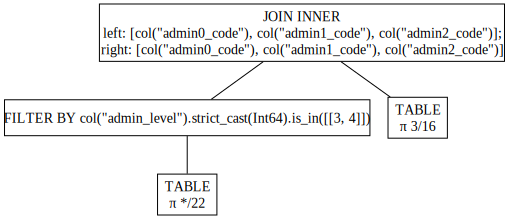

In [72]:
b.show_graph()

In [73]:
# Flexible search with potential place
flex_terms = ["United Kingdom", "London", "Westminster", "Parlement"]
flex_results = flexible_search(flex_terms, con)

flex_results[3]

2025-05-04 21:14:00.807 | DEBUG    | __main__:flexible_search:305 - Search terms: ['United Kingdom', 'London', 'Westminster', 'Parlement']
2025-05-04 21:14:00.808 | DEBUG    | __main__:flexible_search:313 - Searching for term 'United Kingdom' at admin level 0
2025-05-04 21:14:00.808 | DEBUG    | __main__:flexible_search:315 - Searching for: 'United Kingdom' in range [0, 1]
2025-05-04 21:14:00.809 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0 OR admin_level = 1)
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want t

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,importance_score,importance_tier,place_score
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f32,u8,f64
6944334,"""Houses of Parliament""","""Houses of Parliament""","""GB""","""ENG""","""GLA""","""P5""",null,"""S""","""ADMF""",0,51.49971,-0.12496,0.35,4,0.415895


In [87]:
st = ["FR", "Provence-Alpes-Côte d'Azur", None, None, "Le Lavandou"]
search_terms = AdminHierarchy.from_list(st)
# Search through the admin hierarchy
results = hierarchical_search(
    search_terms,
    con=con,
    all_cols=True,
)

# Access results for each level
if "country" in results:
    logger.debug("Country results:")
    print(results["country"])
if "admin1" in results:
    logger.debug("Admin1 results:")
    print(results["admin1"])
if "admin2" in results:
    logger.debug(
        "Admin2 results:",
    )
    print(results["admin2"])
if "admin3" in results:
    logger.debug(
        "Admin3 results:",
    )
    print(results["admin3"])
if "admin4" in results:
    logger.debug(
        "Admin4 results:",
    )
    print(results["admin4"])
results["admin4"]

2025-05-04 21:38:52.810 | DEBUG    | __main__:hierarchical_search:232 - Moved last non-null admin level 'Le Lavandou' to place term
2025-05-04 21:38:52.811 | DEBUG    | __main__:search_admin_hierarchy:127 - Searching for term 'FR' at admin level 0
2025-05-04 21:38:52.819 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT *, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0) AND (admin_level != 0 OR geonameId NOT IN (3017382))
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter push down.
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC
    LIMIT $limit
    
2025-05-04 2

shape: (10, 33)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ geonameId ┆ name      ┆ asciiname ┆ admin_lev ┆ … ┆ average_p ┆ parent_fa ┆ base_scor ┆ adjusted │
│ ---       ┆ ---       ┆ ---       ┆ el        ┆   ┆ arent_sco ┆ ctor      ┆ e         ┆ _score_1 │
│ u32       ┆ str       ┆ str       ┆ ---       ┆   ┆ re        ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ u8        ┆   ┆ ---       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2985244   ┆ Provence- ┆ Provence- ┆ 1         ┆ … ┆ 0.746891  ┆ 1.0       ┆ 0.869319  ┆ 0.81716  │
│           ┆ Alpes-Côt ┆ Alpes-Cot ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ e d'Azur  ┆ e d'Azur  ┆           ┆   ┆           ┆          

KeyError: 'admin4'

In [ ]:
results["admin4"]

geonameId,name,asciiname,admin_level,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,ISO,ISO3,ISO_Numeric,official_name,fips,latitude,longitude,population,area,alternatenames,country_name,fts_score_4,adjusted_score_0,adjusted_score_1,z_score,text_score,pop_score,feature_score,country_score,average_parent_score,parent_factor,base_score,adjusted_score_4
u32,str,str,u8,str,str,str,str,str,str,str,str,str,u16,str,str,f32,f32,i32,f32,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
6615009,"""Le Lavandou""","""Le Lavandou""",4,"""FR""","""93""","""83""","""832""","""83070""","""A""","""ADM4""",null,null,null,null,null,43.137779,6.36778,5759,null,"""83070,Le Lavandou""","""Republic of France""",12.610318,0.746891,0.81716,4.949631,1.0,0.556236,0.55,0.8,0.782025,1.0,0.777183,0.730552
6456407,"""Le Mans""","""Le Mans""",4,"""FR""","""52""","""72""","""723""","""72181""","""A""","""ADM4""",null,null,null,null,null,48.004169,0.19694,142991,null,"""72181,Le Mans""","""Republic of France""",3.630964,0.746891,0.568817,-0.214643,0.420197,0.632141,0.55,0.8,0.657854,0.841218,0.577001,0.542381
6455417,"""Le Vésinet""","""Le Vesinet""",4,"""FR""","""11""","""78""","""783""","""78650""","""A""","""ADM4""",null,null,null,null,null,48.89389,2.13222,16047,null,"""78650,Le Vesinet,Le Vésinet""","""Republic of France""",3.724332,0.746891,0.569015,-0.160945,0.439937,0.583645,0.55,0.8,0.657953,0.841345,0.566956,0.532938
6456500,"""Le Mesnil-le-Roi""","""Le Mesnil-le-Roi""",4,"""FR""","""11""","""78""","""783""","""78396""","""A""","""ADM4""",null,null,null,null,null,48.936668,2.12667,6276,null,"""78396,Le Mesnil-le-Roi""","""Republic of France""",3.822629,0.746891,0.569015,-0.104411,0.460926,0.558673,0.55,0.8,0.657953,0.841345,0.565561,0.531628
6456504,"""Le Pecq""","""Le Pecq""",4,"""FR""","""11""","""78""","""783""","""78481""","""A""","""ADM4""",null,null,null,null,null,48.896671,2.10611,15880,null,"""78481,Le Pecq""","""Republic of France""",3.630964,0.746891,0.569015,-0.214643,0.420197,0.583383,0.55,0.8,0.657953,0.841345,0.559955,0.526357
6457186,"""Le Raincy""","""Le Raincy""",4,"""FR""","""11""","""93""","""932""","""93062""","""A""","""ADM4""",null,null,null,null,null,48.89917,2.52306,14501,null,"""93062,Le Raincy""","""Republic of France""",3.630964,0.746891,0.569015,-0.214643,0.420197,0.581087,0.55,0.8,0.657953,0.841345,0.559151,0.525602
6455961,"""Le Versoud""","""Le Versoud""",4,"""FR""","""84""","""38""","""381""","""38538""","""A""","""ADM4""",null,null,null,null,null,45.216,5.8625,4797,null,"""38538,Le Versoud""","""Republic of France""",3.630964,0.746891,0.665994,-0.214643,0.420197,0.550963,0.55,0.8,0.706443,0.90335,0.557909,0.524434
6455917,"""Le Poinçonnet""","""Le Poinconnet""",4,"""FR""","""24""","""36""","""362""","""36159""","""A""","""ADM4""",null,null,null,null,null,46.763889,1.71889,5870,null,"""36159,Le Poinconnet,Le Poinçon…","""Republic of France""",3.724332,0.746891,0.568638,-0.160945,0.439937,0.556779,0.55,0.8,0.657765,0.841104,0.557516,0.524065
6456350,"""Le Perréon""","""Le Perreon""",4,"""FR""","""84""","""69""","""692""","""69151""","""A""","""ADM4""",null,null,null,null,null,46.063061,4.60056,1566,null,"""69151,Le Perreyon,Le Pèrreyon,…","""Republic of France""",3.782694,0.746891,0.665994,-0.127379,0.452378,0.515722,0.55,0.8,0.706443,0.90335,0.556837,0.523427


In [ ]:
s = flexible_search(st, con=con, limit=10)

d = s[1]

admin_cols = sorted(
    [c for c in d.columns if c.startswith("admin") and c.endswith("_code")]
)
admin_cols

2025-05-04 15:12:45.392 | DEBUG    | __main__:flexible_search:137 - Search terms: ['FR', "Provence-Alpes-Côte d'Azur", 'Le Lavandou']
2025-05-04 15:12:45.393 | DEBUG    | __main__:flexible_search:144 - Searching for term 'FR' at admin level 0
2025-05-04 15:12:45.393 | DEBUG    | __main__:flexible_search:146 - Searching for: 'FR' in range [0, 1, 2]
2025-05-04 15:12:45.399 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0 OR admin_level = 1 OR admin_level = 2) AND (admin_level != 0 OR geonameId NOT IN (3017382))
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will 

['admin0_code', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code']

In [ ]:
r = search_admin("England", [0, 1], con)
# First find the administrative region
admin_results = search_admin("Dover", [3, 4], con, r)
admin_results

2025-05-04 15:12:53.935 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0 OR admin_level = 1)
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter push down.
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC
    LIMIT $limit
    
2025-05-04 15:12:53.999 | WARNING  | __main__:search_score_admin:178 - No parent score column found. Skipping parent factor.
2025-05-04 15:12:54.003 | DEB

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,adjusted_score_0,adjusted_score_3
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f64,f64
7296052,"""Dover""","""Dover""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""A""","""ADM4""",0,51.126282,1.30099,0.756593,0.58045
2651049,"""Dover District""","""Dover District""","""GB""","""ENG""","""G5""","""29UE""",null,"""A""","""ADM3""",114227,51.150002,1.23333,0.756593,0.523773


In [ ]:
# Then search for places within that region
place_results = search_place(
    "Dover Ferry Terminal",
    con,
    previous_results=admin_results,
    limit=50,
)

place_results

2025-05-04 15:16:54.095 | DEBUG    | __main__:search_place:182 - Searching for places with term: Dover Ferry Terminal
2025-05-04 15:16:54.097 | DEBUG    | __main__:search_place:234 - No center point provided. Using centroid of previous results.
2025-05-04 15:16:54.097 | DEBUG    | __main__:search_place:245 - Using center point from previous results: (51.13814163208008, 1.2671599388122559)
2025-05-04 15:16:54.097 | DEBUG    | __main__:search_place:264 - Executing FTS query: 
    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,importance_score,importance_tier,
            fts_main_places_search.match_bm25(geonameId, $term) AS fts_score
        FROM places_search
        WHERE ((admin0_code = 'GB' AND admin1_code = 'ENG' AND admin2_code = 'G5' AND admin3_code = '29UE') OR (admin0_code = 'GB' AND admin1_code = 'ENG' AND admin2_code = 'G5' AND admin3_code =

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,importance_score,importance_tier,place_score
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f32,u8,f64
9253020,"""Dover Port""","""Dover Port""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""L""","""PRT""",0,51.126041,1.32795,0.495,3,0.780731
7284378,"""Dover Transmitting Station""","""Dover Transmitting Station""","""GB""","""ENG""","""G5""","""29UE""","""29UE010""","""S""","""TOWR""",0,51.111698,1.24746,0.66,2,0.735205
6287214,"""Dover Castle""","""Dover Castle""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""S""","""CSTL""",0,51.129581,1.32142,0.715,2,0.712171
6945262,"""Dover Priory Railway Station""","""Dover Priory Railway Station""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""S""","""RSTN""",0,51.12582,1.30501,0.645,2,0.684453
6944960,"""Ramada Dover""","""Ramada Dover""","""GB""","""ENG""","""G5""","""29UE""","""29UE021""","""S""","""HTL""",0,51.167702,1.26965,0.375,4,0.516212
9885608,"""Best Western Dover Marina""","""Best Western Dover Marina""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""S""","""HTL""",0,51.12212,1.31425,0.375,4,0.457329
10281873,"""Dover Marina Hotel and Spa""","""Dover Marina Hotel and Spa""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""S""","""HTL""",0,51.127998,1.3132,0.375,4,0.436059
2651048,"""Dover""","""Dover""","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""P""","""PPL""",41709,51.12598,1.31257,0.381011,4,0.411717
10107778,"""Best Western Plus Dover Marina…","""Best Western Plus Dover Marina…","""GB""","""ENG""","""G5""","""29UE""","""29UE033""","""S""","""HTL""",0,51.121799,1.31413,0.375,4,0.403451


In [ ]:
r = search_admin("England", [0, 1], con)
a = search_admin("Islington", [1, 2, 3], con, r)
b = search_place(
    "Caledonian Road",
    con,
    previous_results=a,
    limit=50,
)
b


2025-05-04 15:17:17.170 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0 OR admin_level = 1)
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter push down.
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC
    LIMIT $limit
    
2025-05-04 15:17:17.224 | WARNING  | __main__:search_score_admin:178 - No parent score column found. Skipping parent factor.
2025-05-04 15:17:17.226 | DEB

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,importance_score,importance_tier,place_score
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f32,u8,f64
6952211,"""Caledonian Road & Barnsbury Ra…","""Caledonian Road & Barnsbury Ra…","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""RSTN""",0,51.543449,-0.11492,0.635,2,0.925274
6954652,"""Caledonian Road Underground St…","""Caledonian Road Underground St…","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""MTRO""",0,51.548538,-0.11823,0.485,3,0.713496
10115056,"""Caledonian Road Apartments""","""Caledonian Road Apartments""","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""HTL""",0,51.542461,-0.11744,0.375,4,0.668034
6952558,"""Essex Road Railway Station""","""Essex Road Railway Station""","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""RSTN""",0,51.5406,-0.0963,0.645,2,0.594382
12048395,"""Caledonian""","""Caledonian""","""GB""","""ENG""","""GLA""","""G3""",null,"""P""","""PPLX""",0,51.540482,-0.11897,0.1,5,0.450015
9259001,"""Caledoninan Road""","""Caledoninan Road""","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""HTL""",0,51.54245,-0.11744,0.375,4,0.418297
2646740,"""Holloway Road Underground Stat…","""Holloway Road Underground Stat…","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""MTRO""",0,51.552792,-0.11282,0.485,3,0.409473
9259906,"""Travelodge Central City Road""","""Travelodge Central City Road""","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""HTL""",0,51.52282,-0.08719,0.375,4,0.390436
6954632,"""Arsenal Underground Station""","""Arsenal Underground Station""","""GB""","""ENG""","""GLA""","""G3""",null,"""S""","""MTRO""",0,51.558441,-0.10572,0.495,3,0.379636


In [ ]:
backfill_hierarchy(
    {
        "admin0_code": "GB",
        "admin1_code": "ENG",
        "admin2_code": "GLA",
        "admin3_code": "G3",
        "geonameId": 13269818,
    },
    con,
)

0
1
2
3
4


{'admin0': {'geonameId': 2635167,
  'name': 'United Kingdom of Great Britain and Northern Ireland'},
 'admin1': {'geonameId': 2634259, 'name': 'West Suffolk'},
 'admin2': {'geonameId': 2648110, 'name': 'Greater London'},
 'admin3': {'geonameId': 3333156, 'name': 'Islington'}}

In [ ]:
results = hierarchical_search(
    search_terms=AdminHierarchy.from_list([None, "FL", None, "Lakeland", None, None]),
    con=con,
    try_place_as_admin=False,
)
row = results["admin3"].row(0, named=True)


pprint(row)

pprint(backfill_hierarchy(row, con))

2025-05-04 21:41:13.161 | DEBUG    | __main__:search_admin_hierarchy:127 - Searching for term 'FL' at admin level 1
2025-05-04 21:41:13.162 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 1)
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter push down.
    SELECT * FROM filtered_results
    WHERE fts_score IS NOT NULL
    ORDER BY fts_score DESC
    LIMIT $limit
    
2025-05-04 21:41:13.183 | WARNING  | __main__:search_scor

{'adjusted_score_1': 0.6674183738082736,
 'adjusted_score_3': 0.6025998219254551,
 'admin0_code': 'US',
 'admin1_code': 'FL',
 'admin2_code': '105',
 'admin3_code': '7170309',
 'admin4_code': None,
 'asciiname': 'City of Lakeland',
 'feature_class': 'A',
 'feature_code': 'ADM3',
 'geonameId': 7170309,
 'latitude': 28.05565071105957,
 'longitude': -81.95420837402344,
 'name': 'City of Lakeland',
 'population': 97422}


ParserException: Parser Error: syntax error at or near "WHERE"

In [ ]:
# Search through the admin hierarchy
results = hierarchical_search(
    search_terms=AdminHierarchy.from_list(
        [
            "FR",
            "Provence-Alpes-Côte d'Azur",
            "Var",
            "Arrondissement de Toulon",
            "Le Lavandou",
            None,
        ]
    ),
    con=con,
)

# Access results for each level
if "country" in results:
    logger.debug("Country results:", results["country"])
if "admin1" in results:
    logger.debug("Admin1 results:", results["admin1"])
if "admin2" in results:
    logger.debug("Admin2 results:", results["admin2"])
if "admin3" in results:
    logger.debug("Admin3 results:", results["admin3"])
if "admin4" in results:
    logger.debug("Admin4 results:", results["admin4"])
results["admin4"]

2025-05-04 21:40:52.486 | DEBUG    | __main__:hierarchical_search:232 - Moved last non-null admin level 'Le Lavandou' to place term
2025-05-04 21:40:52.487 | DEBUG    | __main__:search_admin_hierarchy:127 - Searching for term 'FR' at admin level 0
2025-05-04 21:40:52.495 | DEBUG    | __main__:search_admin:364 - Executing FTS query: 

    WITH filtered_results AS (
        SELECT geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude, fts_main_admin_search.match_bm25(geonameId, $term) AS fts_score
        FROM admin_search
        WHERE (admin_level = 0) AND (admin_level != 0 OR geonameId NOT IN (3017382))
    )
    -- Using a CTE to ensure we always filter before the FTS score is calculated. Because of the `WHERE fts_score IS NOT NULL` clause, the FTS score will be calculated for all rows, but we only want to keep those that match the search term, hence the subquery first in order to stop the filter 

geonameId,name,asciiname,admin0_code,admin1_code,admin2_code,admin3_code,admin4_code,feature_class,feature_code,population,latitude,longitude,adjusted_score_0,adjusted_score_1,adjusted_score_2,adjusted_score_3,adjusted_score_4
u32,str,str,str,str,str,str,str,str,str,i32,f32,f32,f64,f64,f64,f64,f64
6615009,"""Le Lavandou""","""Le Lavandou""","""FR""","""93""","""83""","""832""","""83070""","""A""","""ADM4""",5759,43.137779,6.36778,0.746891,0.81716,0.795429,0.777905,0.730552
6457128,"""Le Pradet""","""Le Pradet""","""FR""","""93""","""83""","""832""","""83098""","""A""","""ADM4""",10027,43.10556,6.02333,0.746891,0.81716,0.795429,0.777905,0.568234
6457113,"""Le Beausset""","""Le Beausset""","""FR""","""93""","""83""","""832""","""83016""","""A""","""ADM4""",9637,43.19833,5.80278,0.746891,0.81716,0.795429,0.777905,0.559563
6457122,"""Le Luc""","""Le Luc""","""FR""","""93""","""83""","""833""","""83073""","""A""","""ADM4""",10952,43.394402,6.3134,0.746891,0.81716,0.795429,0.542154,0.558407
6457127,"""Le Muy""","""Le Muy""","""FR""","""93""","""83""","""831""","""83086""","""A""","""ADM4""",9248,43.4725,6.56639,0.746891,0.81716,0.795429,0.540235,0.556842
6456550,"""Le Val""","""Le Val""","""FR""","""93""","""83""","""833""","""83143""","""A""","""ADM4""",4297,43.439442,6.07306,0.746891,0.81716,0.795429,0.542154,0.549818
6456549,"""Le Thoronet""","""Le Thoronet""","""FR""","""93""","""83""","""833""","""83136""","""A""","""ADM4""",2449,43.451939,6.30389,0.746891,0.81716,0.795429,0.542154,0.544131
6456545,"""Le Revest-les-Eaux""","""Le Revest-les-Eaux""","""FR""","""93""","""83""","""832""","""83103""","""A""","""ADM4""",3812,43.176601,5.9273,0.746891,0.81716,0.795429,0.777905,0.529966
6617824,"""Le Castellet""","""Le Castellet""","""FR""","""93""","""83""","""832""","""83035""","""A""","""ADM4""",3875,43.202702,5.777,0.746891,0.81716,0.795429,0.777905,0.527065


In [ ]:
data = (
    con.execute("SELECT geonameId, latitude, longitude FROM allCountries")
    .pl()
    .select(
        pl.col("geonameId"),
        pl.concat_list(pl.col("latitude"), pl.col("longitude"))
        .cast(pl.Array(pl.Float32, 2))
        .alias("vectors"),
    )
)

In [ ]:
my_coordinates1 = np.array([51.549902, -0.121696], dtype=np.float32)
my_coordinates2 = np.array([37.77493, -122.41942], dtype=np.float32)

vidx = VectorIndex("latlon", data, metric="haversine")

In [ ]:
if (path := Path("./data/processed/latlon.index")).exists():
    logger.debug("Loading index...")
    index = Index.restore(path, view=True)
    if index is None:
        raise ValueError("Failed to load index")
else:
    logger.debug("Creating index...")
    coordinates = df.select(["latitude", "longitude"]).to_numpy(order="c")
    labels = df["geonameId"].to_numpy()
    index: Index = Index(ndim=2, metric="haversine", dtype="f32")
    index.add(keys=labels, vectors=coordinates, log=True)
    index.save(path)

In [ ]:
# Example function to search and return results with distances
def search_with_distances(
    index: Index,
    my_coordinates: NDArray[np.float32],
    original_df: pl.LazyFrame,
    k=10,
    exact=False,
):
    # Perform the search
    output = index.search(vectors=my_coordinates, count=k, log=True, exact=exact)

    logger.debug(f"Visited members: {output.visited_members}")
    logger.debug(f"Computed distances: {output.computed_distances}")

    # Extract keys (geonameids) and distances
    keys = output.keys
    distances = output.distances

    # Create a DataFrame from the search results
    results_df = pl.LazyFrame(
        data={"geonameId": keys, "distance": distances},
        schema={"geonameId": pl.UInt32, "distance": pl.Float32},
    ).with_columns(pl.col("distance") * 6371.0)

    # Join the results with the original DataFrame to get detailed information
    detailed_results_df = results_df.join(original_df, on="geonameId", how="left")

    # Sort by distance
    sorted_results_df = detailed_results_df.sort("distance")

    return sorted_results_df.collect()

In [ ]:
search_with_distances(index, my_coordinates2, df.lazy())

In [ ]:
output: Matches = index.search(vectors=my_coordinates1, count=10, log=True)
logger.debug(f"{output.computed_distances=}")
logger.debug(f"{output.visited_members=}")
df.filter(pl.col("geonameId").is_in(output.keys))

In [ ]:
# con.execute(sql_file("create_view_*_NODES.sql", table="admin0"))

# con.execute(sql_file("create_view_*_FTS.sql", table="admin0"))

# # if (path := Path("./data/processed/latlon.index")).exists():
# #     logger.debug("Loading index...")
# #     index = Index.restore(path, view=True) or raise ValueError("Failed to load index")
# # else:
# #     logger.debug("Creating index...")
# #     coordinates = df.select(["latitude", "longitude"]).to_numpy(order="c")
# #     labels = df["geonameid"].to_numpy()
# #     index: Index = Index(ndim=2, metric="haversine", dtype="f32")
# #     index.add(keys=labels, vectors=coordinates, log=True)
# #     index.save(path)


# class VectorIndex:
#     default_index_path = Path("./data/indexes/vector")

#     def __init__(
#         self,
#         index_name: str,
#         data: pl.DataFrame | None = None,
#         id_column: str = "geonameId",
#         main_column: str = "vectors",
#         metric: str = "L2",
#         embedder: SentenceTransformer | None = None,
#     ):
#         self._index_path = self.default_index_path / f"{index_name}.index"
#         self._id_column = id_column
#         self._main_column = main_column
#         self._metric = metric
#         index = self.get_or_build_index(data, metric)
#         if isinstance(index, Err):
#             logger.debug(
#                 f"Index does not exist at '{self.index_path}', build index with 'build_index' method."
#             )
#             self._index = None  # type: ignore
#         else:
#             self._index: Index = index.ok_value

#     @property
#     def index(self) -> Index:
#         return self._index

#     @property
#     def id_column(self) -> str:
#         return self._id_column

#     @property
#     def main_column(self) -> str:
#         return self._main_column

#     @property
#     def index_path(self) -> Path:
#         return self._index_path

#     @property
#     def ndims(self) -> int:
#         return self._ndims

#     @property
#     def metric(self) -> str:
#         return self._metric

#     def _build_index(
#         self,
#         df: pl.DataFrame,
#         metric: str = "L2",  # TODO: Metric like
#     ) -> Result[Index, str]:
#         """Data passed should be an Id and a vector."""
#         logger.debug("Creating index...")
#         vectors = df[self.main_column].to_numpy()
#         labels = df[self.id_column].to_numpy()
#         ndims = vectors.shape[1]  # Find n dims
#         index: Index = Index(ndim=ndims, metric=metric, dtype="f32")
#         index.add(keys=labels, vectors=vectors, log=True)
#         index.save(self.index_path)
#         return Ok(index)

#     def get_index(self) -> Result[Index, str]:
#         if (path := self.index_path).exists():
#             logger.debug(f"Opening index at '{self.index_path}'")
#             index = Index.restore(path, view=True)
#             if index is not None:
#                 return Ok(index)
#         return Err(f"Index does not exist at '{self.index_path}'")

#     def get_or_build_index(
#         self,
#         df: pl.DataFrame | None = None,
#         metric: str = "L2",  # TODO: as above
#     ) -> Result[Index, str]:
#         self.index_path.parent.mkdir(parents=True, exist_ok=True)

#         if not self.index_path.exists():
#             if df is None:
#                 return Err(
#                     "Index does not exist. DataFrame is required to create index"
#                 )
#             match self._build_index(df, metric):
#                 case Ok(index):
#                     ...
#                 case Err(e):
#                     return Err(e)
#         else:
#             match self.get_index():
#                 case Ok(index):
#                     ...
#                 case Err(e):
#                     return Err(e)

#         self._ndims = index.ndim
#         logger.debug("Opening index")
#         return Ok(index)

#     def search(
#         self,
#         query: NDArray[np.float32],
#         limit: int = 10,
#         include: list[int] | None = None,
#         exclude: list[int] | None = None,
#     ) -> Result[pl.DataFrame, str]:
#         return self.vector_search(query, limit, include, exclude)

#     def vector_search(
#         self,
#         query: NDArray[np.float32],
#         limit: int = 10,
#         include: list[int] | None = None,
#         exclude: list[int] | None = None,
#         exact: bool = False,
#     ) -> Result[pl.DataFrame, str]:
#         output = self.index.search(vectors=query, count=limit, log=True, exact=exact)

#         logger.debug(f"Visited members: {output.visited_members}")
#         logger.debug(f"Computed distances: {output.computed_distances}")

#         # Extract keys (geonameids) and distances
#         keys = output.keys
#         distances = output.distances

#         # Create a DataFrame from the search results
#         results_df = pl.LazyFrame(
#             data={self.id_column: keys, "score": distances},
#             schema={self.id_column: pl.UInt32, "score": pl.Float32},
#         )
#         if self.metric == "haversine":
#             results_df = results_df.with_columns(pl.col("score") * 6371.0)

#         results_df = results_df.sort(
#             "score"
#         )  # TODO: ascending descending depending on metric.

#         return Ok(results_df.collect())


# class FTSIndex:
#     default_index_path = Path("./data/indexes/fts")

#     def __init__(
#         self,
#         index_name: str,
#         data: pl.DataFrame | None = None,
#         id_column: str = "geonameId",
#         main_column: str = "name",
#     ):
#         self._index_path = self.default_index_path / index_name
#         self._column_types = {}
#         self._id_column = id_column
#         self._main_column = main_column
#         index = self.get_or_build_index(data)
#         if isinstance(index, Err):
#             logger.debug(
#                 f"Index does not exist at '{self.index_path}', build index with 'build_index' method."
#             )
#             self._index = None  # type: ignore
#         else:
#             self._index: tantivy.Index = index.ok_value

#     @property
#     def index(self) -> tantivy.Index:
#         self._index.reload()
#         return self._index

#     @property
#     def column_types(self) -> dict[str, str]:
#         return self._column_types

#     @property
#     def id_column(self) -> str:
#         return self._id_column

#     @property
#     def main_column(self) -> str:
#         return self._main_column

#     @property
#     def index_path(self) -> Path:
#         return self._index_path

#     @property
#     def columns_not_id(self) -> list[str]:
#         return [col for col in self.column_types if col != self.id_column]

#     def _build_index(
#         self,
#         df: pl.DataFrame,
#         split_field: dict[str, list[str] | str] | None = None,
#     ) -> Result[tantivy.Index, str]:
#         """Only pass in data which you wish to build the ftx index with. split_field is a dictionary of fields to split by a delimiter. eg {",": ["field1", "field2"]} will split field1 and field2 by comma."""
#         # TODO: this programmatically into tantivy schema
#         schema_builder = tantivy.SchemaBuilder()

#         if self.id_column not in df.columns:
#             return Err(f"'{self.id_column}' column not found in DataFrame")

#         col_types = {}
#         for col in df.columns:
#             if col == self.id_column:
#                 schema_builder.add_integer_field(
#                     self.id_column, stored=True, indexed=True, fast=True
#                 )
#             # TODO: ADD support for other types
#             else:
#                 schema_builder.add_text_field(col)
#             col_types[col] = df[col].dtype._string_repr()

#         self._column_types = col_types

#         schema = schema_builder.build()
#         logger.debug(f"Creating index with columns:\n{json.dumps(col_types, indent=2)}")

#         index = tantivy.Index(schema, path=self.index_path.as_posix(), reuse=False)
#         writer = index.writer()
#         for row in df.rows(named=True):
#             if split_field:
#                 for splitter, fields in split_field.items():
#                     if isinstance(fields, str):
#                         fields = [fields]
#                     for field in fields:
#                         logger.debug(f"Splitting {field} by {splitter}...")
#                         row[field] = row[field].split(splitter)
#             writer.add_document(tantivy.Document(**row))
#         writer.commit()
#         writer.wait_merging_threads()
#         return Ok(index)

#     def get_index(self) -> Result[tantivy.Index, str]:
#         if tantivy.Index.exists(self.index_path.as_posix()):
#             logger.debug(f"Opening index at '{self.index_path}'")
#             return Ok(tantivy.Index.open(self.index_path.as_posix()))
#         return Err(f"Index does not exist at '{self.index_path}'")

#     def get_or_build_index(
#         self, df: pl.DataFrame | None = None
#     ) -> Result[tantivy.Index, str]:
#         if not self.index_path.exists() and df is None:
#             return Err("Index does not exist. DataFrame is required to create index")

#         self.index_path.mkdir(parents=True, exist_ok=True)

#         if not tantivy.Index.exists(self.index_path.as_posix()):
#             if df is None:
#                 return Err("DataFrame is required to create index")
#             match self._build_index(df):
#                 case Ok(index):
#                     ...
#                 case Err(e):
#                     return Err(e)
#         else:
#             match self.get_index():
#                 case Ok(index):
#                     ...
#                 case Err(e):
#                     return Err(e)
#         schema = json.loads((self.index_path / "meta.json").read_text())["schema"]
#         sc = {}
#         for v in schema:
#             type_ = v["type"]
#             if type_ == "text":
#                 type_ = pl.Utf8
#             elif type_ == "i64":
#                 type_ = pl.UInt32
#             sc[v["name"]] = type_

#         self._column_types = sc
#         logger.debug("Schema Loaded")
#         logger.debug("Opening country index")
#         return Ok(index)

#     def convert_fts_results(
#         self, hits: tantivy.SearchResult, searcher: tantivy.Searcher
#     ) -> pl.DataFrame:
#         logger.debug(f"FTS hits from search: {hits.count}")  # type: ignore

#         scores, gids = zip(
#             *[
#                 (score, searcher.doc(doc).get_first(self.id_column))
#                 for score, doc in hits.hits
#             ]
#         )

#         return (
#             pl.LazyFrame(
#                 {"geonameId": list(gids), "score": list(scores)},
#                 schema={"geonameId": pl.UInt32, "score": pl.Float32},
#             )
#             .sort("score", descending=True, maintain_order=True)
#             .collect()
#         )

#     def search(
#         self,
#         query: str,
#         limit: int = 10,
#         include: list[int] | None = None,
#         exclude: list[int] | None = None,
#     ) -> Result[pl.DataFrame, str]:
#         return self.fts_search(
#             query,
#             limit=limit,
#             include=include,
#             exclude=exclude,
#         )

#     def fts_search(
#         self,
#         query: str,
#         limit: int = 10,
#         include: list[int] | None = None,
#         exclude: list[int] | None = None,
#         main_term_query_boost: float = 3.0,
#         fuzzy_term_query_boost: float = 2.0,
#         max_fuzzy_distance: int = 2,
#         phrase: bool = True,
#     ) -> Result[pl.DataFrame, str]:
#         # Create for list of queries (batch search)
#         if phrase:
#             query = f"'{query}'"
#         else:
#             query = query.strip("\"'")
#         query = query.strip()
#         index = self.index

#         searcher = index.searcher()

#         bool_query_list: list[tuple[tantivy.Occur, tantivy.Query]] = []

#         # Calculate fuzzy distance based on query length
#         fuzzy_distance = min(max(0, len(query) - 2), max_fuzzy_distance)

#         if self.main_column in self.columns_not_id:
#             main_term_query = tantivy.Query.term_query(
#                 index.schema, self.main_column, query
#             )
#             bool_query_list.append(
#                 (
#                     tantivy.Occur.Should,
#                     tantivy.Query.boost_query(main_term_query, main_term_query_boost),
#                 )
#             )

#             if fuzzy_distance > 0:
#                 main_fuzzy_query = tantivy.Query.fuzzy_term_query(
#                     index.schema, self.main_column, query, distance=fuzzy_distance
#                 )

#                 bool_query_list.append(
#                     (
#                         tantivy.Occur.Should,
#                         tantivy.Query.boost_query(
#                             main_fuzzy_query, fuzzy_term_query_boost
#                         ),
#                     )
#                 )

#             rest_of_query = index.parse_query(
#                 query, list(set(self.columns_not_id) - {self.main_column})
#             )
#             bool_query_list.append((tantivy.Occur.Should, rest_of_query))

#         if include:
#             bool_query_list.append(
#                 (
#                     tantivy.Occur.Must,
#                     tantivy.Query.term_set_query(index.schema, self.id_column, include),
#                 )
#             )
#         if exclude:
#             bool_query_list.append(
#                 (
#                     tantivy.Occur.MustNot,
#                     tantivy.Query.term_set_query(index.schema, self.id_column, exclude),
#                 )
#             )
#         if bool_query_list:
#             final_query = tantivy.Query.boolean_query(bool_query_list)

#         else:
#             final_query: tantivy.Query = index.parse_query(
#                 query, default_field_names=self.columns_not_id
#             )

#         logger.debug(final_query)

#         hits: tantivy.SearchResult = searcher.search(final_query, limit=limit)

#         if hits.count == 0:  # type: ignore
#             if phrase:
#                 logger.debug("No results found, retrying without phrase search...")
#                 return self.fts_search(
#                     query,
#                     limit,
#                     include,
#                     exclude,
#                     main_term_query_boost,
#                     fuzzy_term_query_boost,
#                     max_fuzzy_distance,
#                     phrase=False,
#                 )
#             return Err("No results found")

#         return Ok(self.convert_fts_results(hits, searcher))


# class HybridIndex:
#     def __init__(self, fts_idx: FTSIndex, vidx: VectorIndex):
#         self._fts_idx = fts_idx
#         self._vidx = vidx

#     @property
#     def vector_index(self) -> VectorIndex:
#         return self._vidx

#     @property
#     def fts_index(self) -> FTSIndex:
#         return self._fts_idx

#     def search(
#         self,
#         query: str,
#         limit: int = 10,
#         include: list[int] | None = None,
#         exclude: list[int] | None = None,
#         main_term_query_boost: float = 3.0,
#         fuzzy_term_query_boost: float = 2.0,
#         max_fuzzy_distance: int = 2,
#         phrase: bool = True,
#     ) -> Result[pl.DataFrame, str]:
#         v_search = self.vector_index.vector_search


# country_index = FTSIndex("admin0", con.table("admin0_FTS").pl())
# country_index.fts_search("An Danmhairg").unwrap().join(
#     con.table("admin0").pl(), "geonameId", "left"
# )